## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'ravdess-fullgeocomp' #dataset-compression
TRANSFORM = 'fft-male' #transform-group
CHANNEL = ''    

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
male_fft_1e5geocomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geocomp\\fft\\male'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
#group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data","raw-transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
group_data_map.keys()
group_total_samples = {}
for i in group_data_map:
    group_total_samples[i] = len(group_data_map[i])

## Subsample data

In [ ]:
for i in group_data_map:
    if len(group_data_map[i]) > SUBSAMPLE_SIZE:
        factor = int(len(group_data_map[i]) // SUBSAMPLE_SIZE)
        clone = []
        for i in range(SUBSAMPLE_SIZE):
            clone.extend([group_data_map[int(factor * i)]])
        clone = np.array(clone)
    else:
        clone = group_data_map[i]
    group_data_map[i] = clone

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map

Running 12760 CDFs


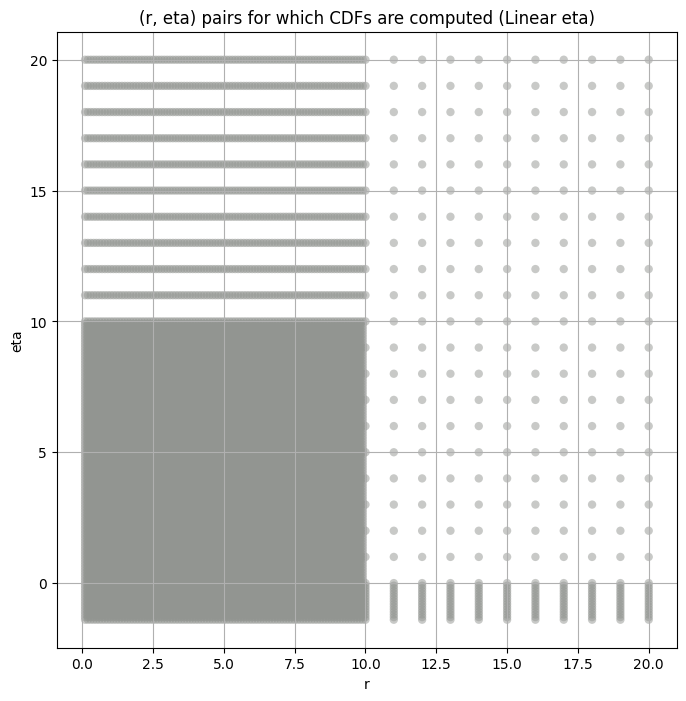

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [ ]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [ ]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [ ]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 29


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,4.001831e+14,3.431550e+14,4.662308e+14,8.374412,4.737162,11.637278,2880.0
5,9.456641e+14,8.243140e+14,1.077068e+15,21.406433,18.218009,24.826738,8640.0
8,1.933607e+14,1.665212e+14,2.231191e+14,30.021908,21.785601,39.655766,24480.0
11,1.434549e+13,1.161038e+13,1.892118e+13,97.998144,13.797226,269.245611,67680.0
14,2.651968e+14,2.382959e+14,2.953186e+14,15.607562,10.288634,23.901440,100000.0
17,2.954061e+14,2.793516e+14,3.129828e+14,2.845135,1.622554,6.986594,100000.0
20,5.450353e+13,5.015239e+13,6.068562e+13,10.791890,3.758170,43.044204,100000.0
23,1.058599e+13,1.000795e+13,1.124110e+13,3.116213,1.811750,8.640072,100000.0
26,2.922161e+12,2.731516e+12,3.139131e+12,5.226006,3.111765,13.530244,100000.0


## Initial Grid Search and Hypothesis Test Plots

In [ ]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [ ]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,4.001831e+14,4.001831e+14,2.676424e+14,2.274712e+14,2.009417e+14,1.811547e+14,1.511413e+14,1.278060e+14,1.092223e+14,9.436583e+13,8.212255e+13,5.485210e+13
5,9.456641e+14,9.456641e+14,6.703366e+14,5.282018e+14,4.394309e+14,3.760049e+14,2.937948e+14,2.401797e+14,2.026238e+14,1.748467e+14,1.536598e+14,1.145680e+14
8,1.933607e+14,1.933607e+14,1.568992e+14,1.378659e+14,1.253755e+14,1.153402e+14,9.958091e+13,8.793345e+13,7.884544e+13,7.178500e+13,6.617606e+13,5.455246e+13
11,1.434549e+13,1.434549e+13,1.146962e+13,1.081302e+13,1.045280e+13,1.017548e+13,9.763818e+12,9.442922e+12,9.170002e+12,8.940300e+12,8.739836e+12,8.259110e+12
14,2.651968e+14,2.651968e+14,2.565584e+14,2.513110e+14,2.468247e+14,2.430991e+14,2.368006e+14,2.314885e+14,2.267500e+14,2.223878e+14,2.182976e+14,2.075533e+14
17,2.954061e+14,2.954061e+14,2.909610e+14,2.881084e+14,2.856913e+14,2.835224e+14,2.796606e+14,2.761952e+14,2.730288e+14,2.700864e+14,2.673334e+14,2.598508e+14
20,5.450353e+13,5.450353e+13,5.271118e+13,5.183029e+13,5.112677e+13,5.052309e+13,4.949072e+13,4.860797e+13,4.782791e+13,4.711849e+13,4.646540e+13,4.475348e+13
23,1.058599e+13,1.058599e+13,1.039696e+13,1.027463e+13,1.016900e+13,1.007332e+13,9.902302e+12,9.749987e+12,9.611079e+12,9.482741e+12,9.362866e+12,9.041636e+12
26,2.922161e+12,2.922161e+12,2.853721e+12,2.809943e+12,2.772683e+12,2.739380e+12,2.680573e+12,2.628914e+12,2.582385e+12,2.539772e+12,2.500263e+12,2.395676e+12


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.037611271654568235 400183110841747.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.03775235221296008 267642421763642.72


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.04003244297644981 227471227840961.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.045740280652671106 200941658842706.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.05331263345060855 181154706029957.88


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.07326922932107571 151141326085039.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.09231349526910249 127805972146652.64


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.11027914437500985 109222266550652.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.12685858901602554 94365828675012.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.14258891080976066 82122548326458.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.1861711693436756 54852104769388.65
Number of samples: 2880, Without approximation : 2880.0


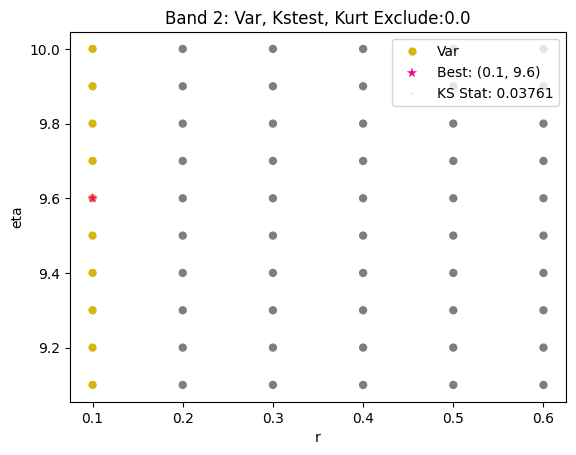

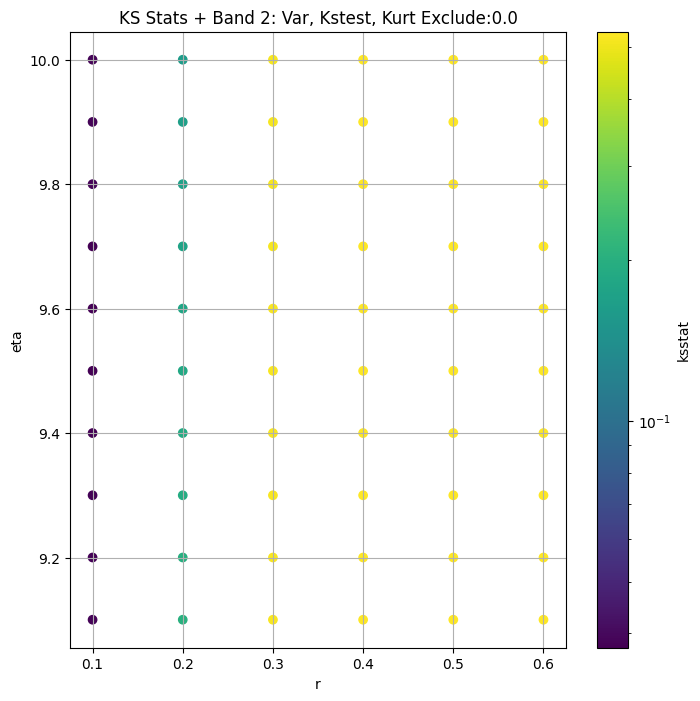

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.03846999488605227 945664078461412.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.03170791429002462 670336649641957.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.02821005528190601 528201800465930.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.026191469458182515 439430929320777.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.02474541685139975 376004944022570.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.025534299491943524 293794760894511.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.029483736606521926 240179658850842.88


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.034677273412362264 202623786971742.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.04005306550255627 174846709629367.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.04605787775140846 153659809287831.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.06208572492353703 114568046897131.06
Number of samples: 8640, Without approximation : 8640.0


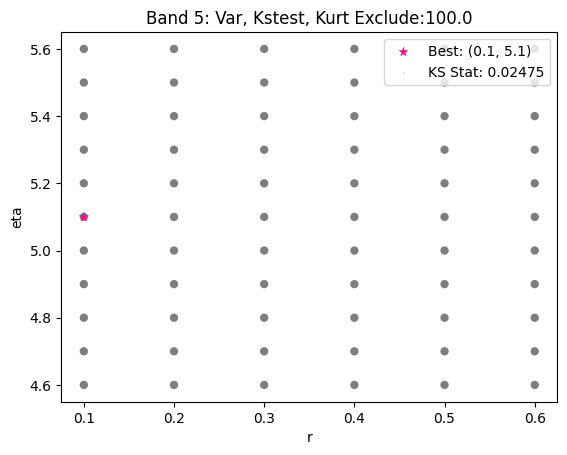

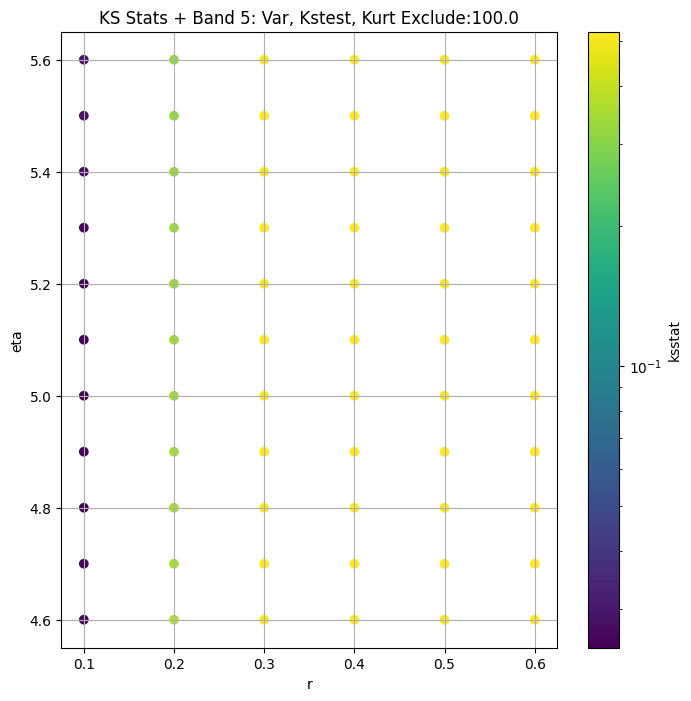

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.023749204189151874 193360740671751.88


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.023749204189151874 156899249469075.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.023749204189151874 137865850750900.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.023749204189151874 125375501793575.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.023749204189151874 115340170823347.23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.021430884314647736 99580913820581.55


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.0195494837256881 87933453584094.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.018368674580637845 78845444766077.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.018414847197768425 71785001652756.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.019642478761758477 66176058927539.695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.02526880136599524 54552456038527.805
Number of samples: 24480, Without approximation : 24480.0


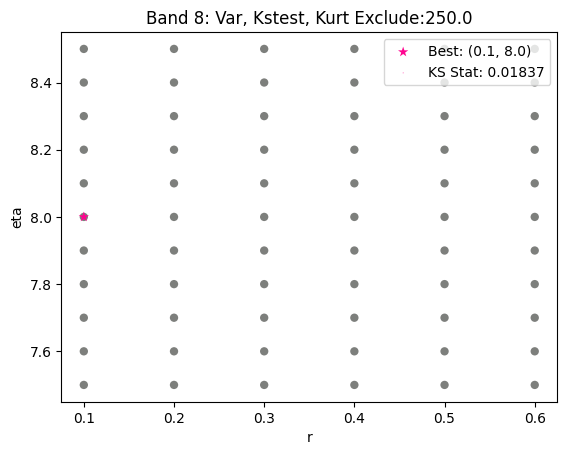

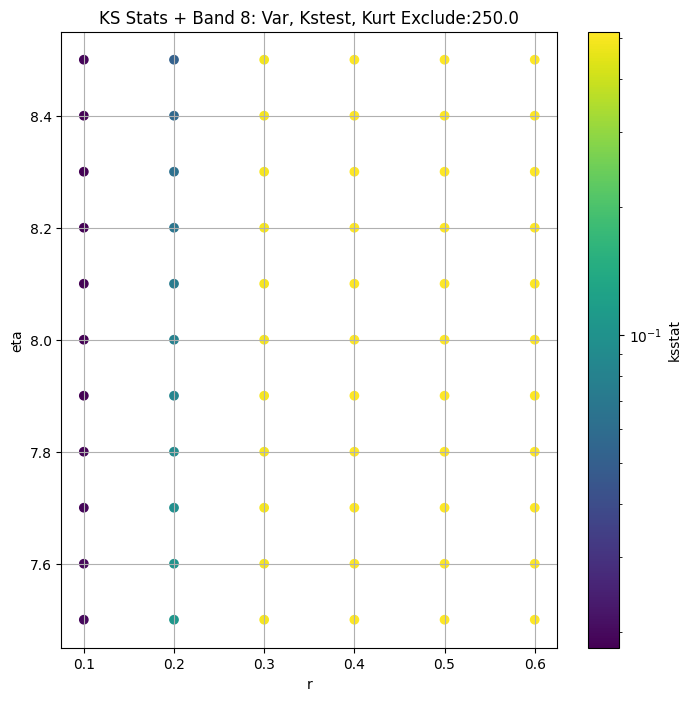

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.007542461203942696 14345485181909.357


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.007542461203942696 11469615544648.646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.007542461203942696 10813017278543.252


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.007252680854705401 10452796582917.295


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.006051397749919807 10175480479255.727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.00428090663502409 9763818291062.88


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.004514840921808538 9442922209778.535


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.005279171857337173 9170001571118.111


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.005862408294998733 8940299735283.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.006405245740774834 8739836154099.936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.00934257622801582 8259110268387.55
Number of samples: 67680, Without approximation : 67680.0


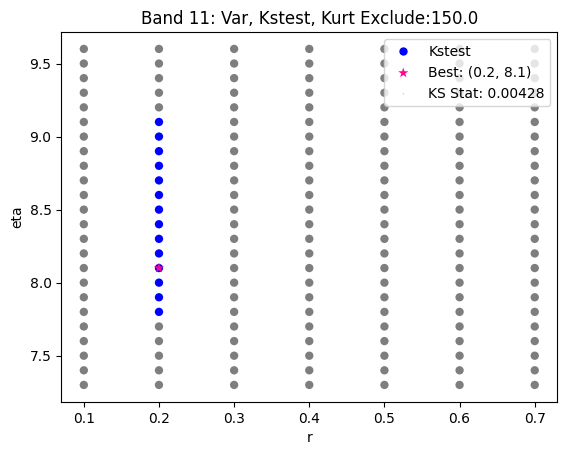

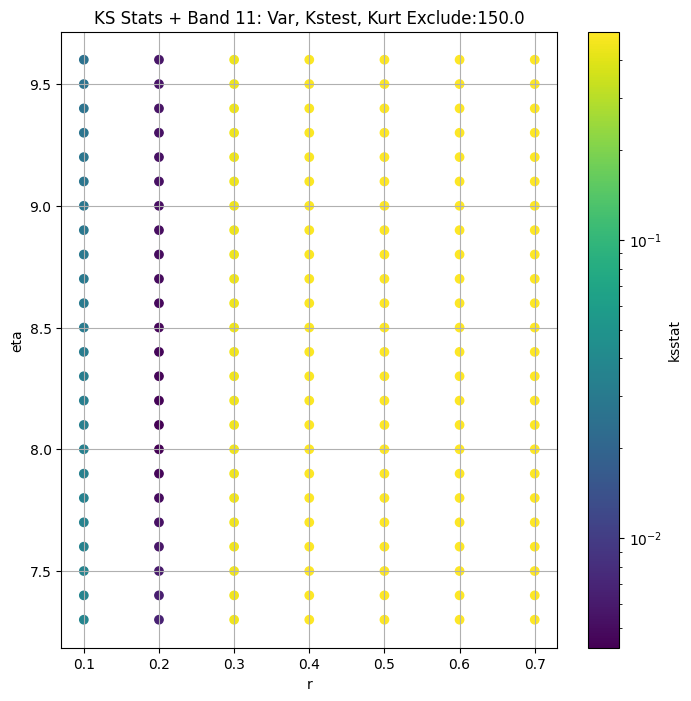

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.44049987801329227 265196808520432.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.44049987801329227 256558423077402.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.44049987801329227 251311020749658.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.4400721921997379 246824736596911.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.43967698606895833 243099076326729.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.43989421094127434 236800625306505.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.44010693778814225 231488544247345.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.440302776236603 226750007901089.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.44048839408062107 222387815713943.72


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.44049987801329227 218297621909966.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.43968523790414005 207553319670338.7
Number of samples: 100000, Without approximation : 100000.0


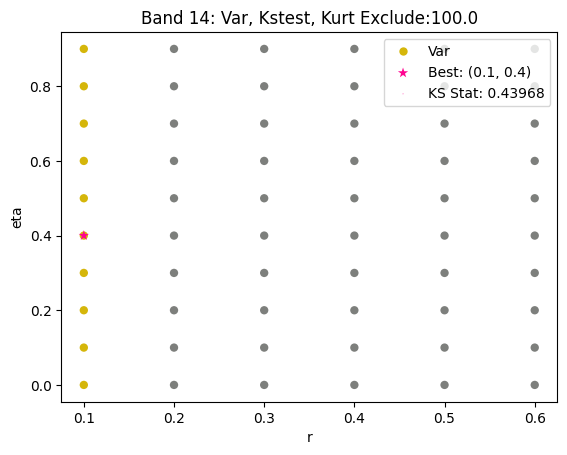

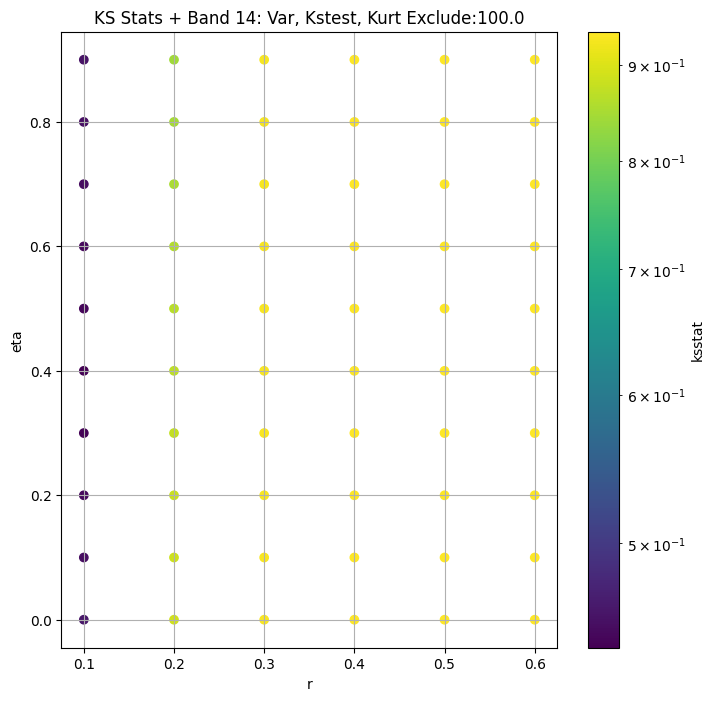

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.026901091548847483 295406105999192.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.028487467672775407 290961006640085.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.029517412271896887 288108423599248.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.03039753916158358 285691305628951.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.031193937532299876 283522364871694.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.030258713150757233 279660608921432.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.029260057895135194 276195167874851.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.028408459908763284 273028763914249.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.027604966990041557 270086415607397.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.026861069788521097 267333430424080.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.02761523152861757 259850777699376.38
Number of samples: 100000, Without approximation : 100000.0


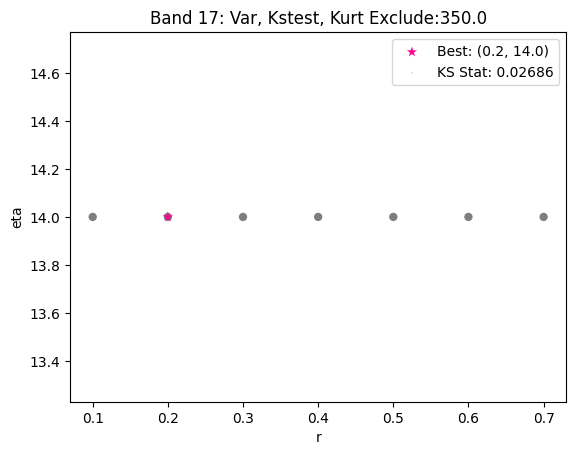

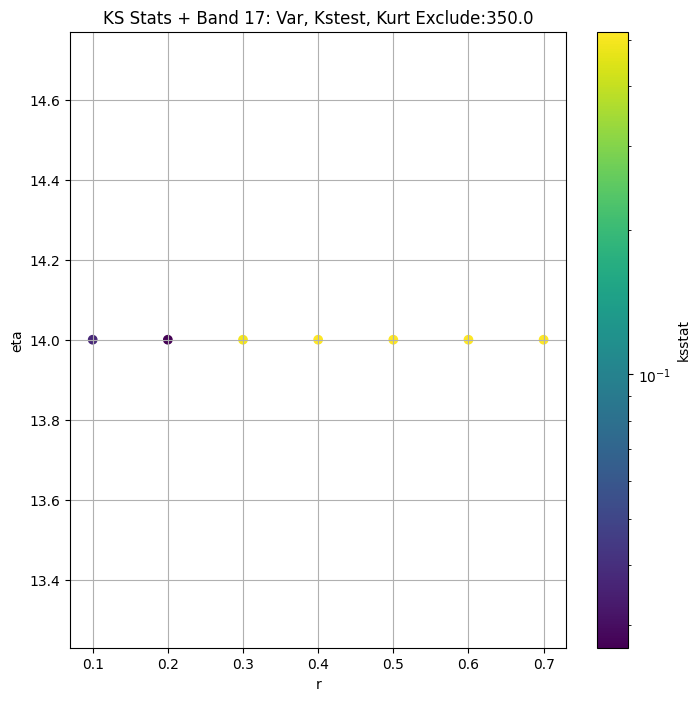

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.01996730889059753 54503531914767.984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.01973014004183471 52711184267162.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.019021305837617852 51830286263171.99


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.01856050956892319 51126765643474.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.018190403699273827 50523090795227.92


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.017361528877421373 49490719631125.586


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.017731697775853303 48607970663260.64


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.01907864254803382 47827910850071.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.01996730889059753 47118494227347.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.01996730889059753 46465398083277.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.021361648353883746 44753477633246.19
Number of samples: 100000, Without approximation : 100000.0


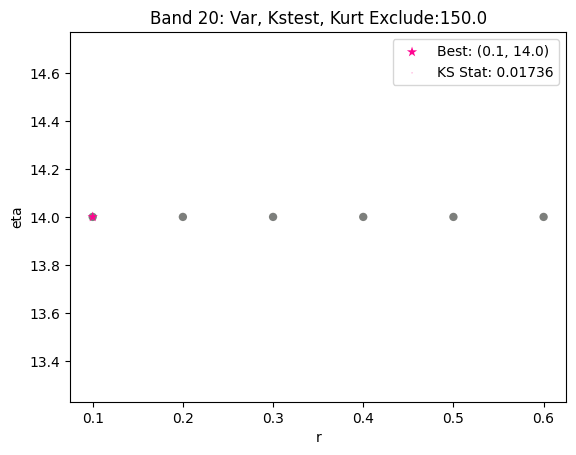

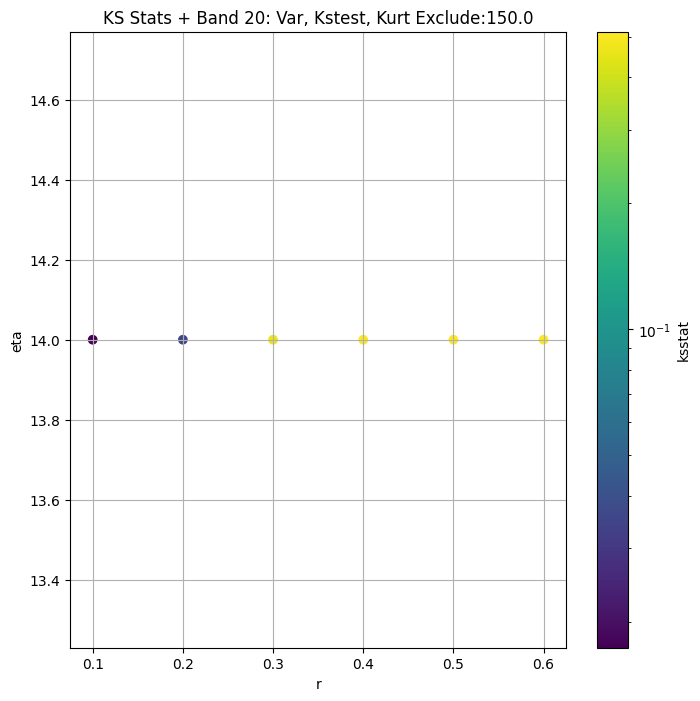

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0020037618301408378 10585992784056.541


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.002221891257128898 10396960793912.223


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.002572014359694605 10274632951872.697


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0030729954160866046 10169003506220.877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0035493667522911512 10073323772116.146


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.004429233442348718 9902302051069.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.005249873496722665 9749986984597.965


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.006027358841187325 9611079461970.928


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.006771888386577184 9482740578223.771


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.007494973560559413 9362866430791.498


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.00953438135586477 9041636154458.088
Number of samples: 100000, Without approximation : 100000.0


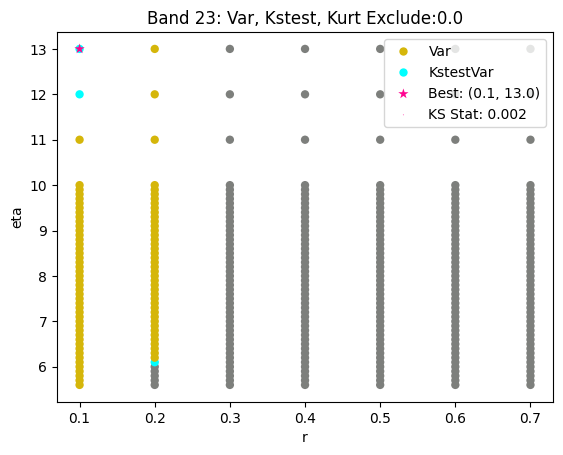

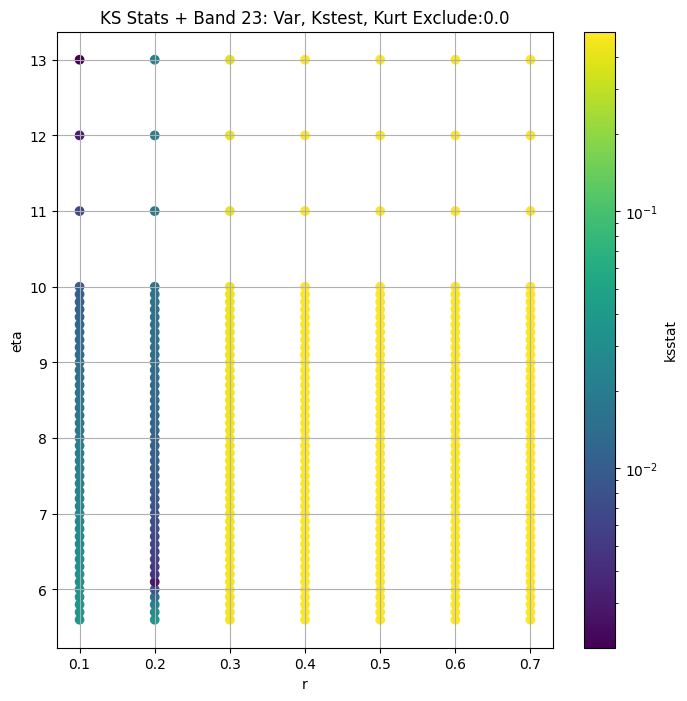

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.002315202716388118 2922160721669.784


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0032676352319986474 2853720783639.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.003774559162654567 2809943426935.955


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0043357767805805025 2772682628576.879


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.004862921693838597 2739380278125.882


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.0057348333886510575 2680573175652.407


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.0065793849022927064 2628913750260.035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.006921460024959476 2582385495868.2896


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.007692580268429165 2539771613769.809


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.008437491648498309 2500262988466.3037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.010536864824359657 2395675901367.3154
Number of samples: 100000, Without approximation : 100000.0


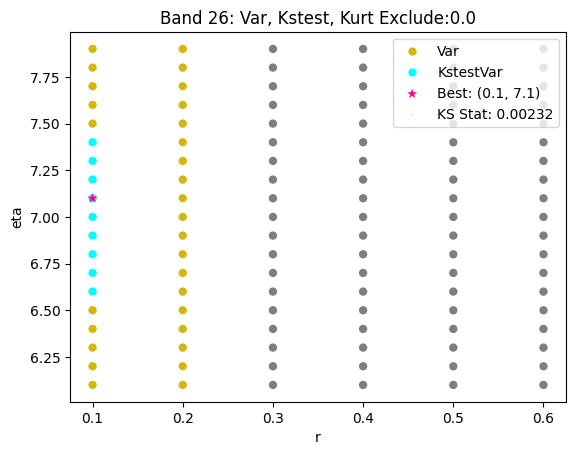

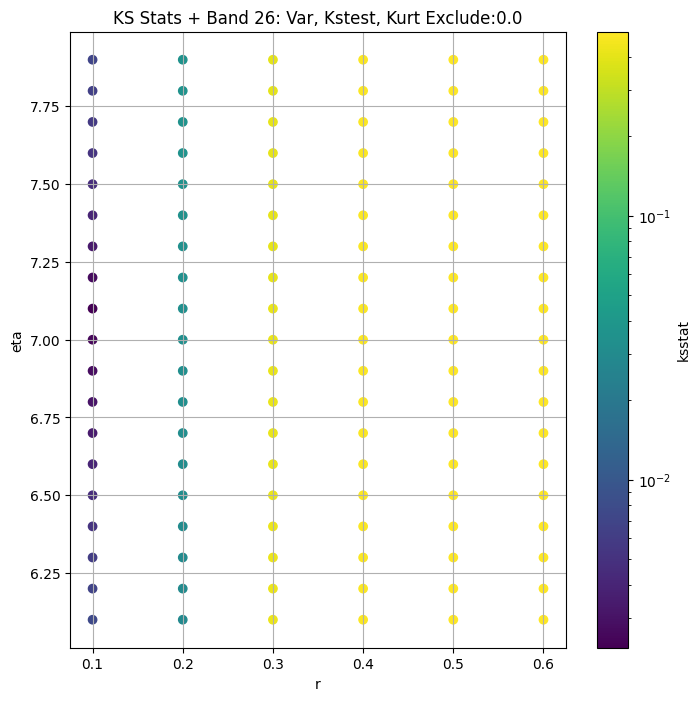

####
Band  29


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 0 0.0030849426229090093 63717506363.97226


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 25 0.0040694214437148185 62271402993.634285


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 50 0.004622946242499884 61299594294.33173


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 75 0.005103876521812906 60457763301.36296


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 100 0.005539137335254851 59699636524.74617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 150 0.006621339788427896 58353840163.701


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 200 0.007313981091606615 57167650629.528984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 250 0.00800611494957934 56095785444.41759


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 300 0.008847404798893552 55111667714.810555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 350 0.009489760381824648 54198269448.30115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 500 0.01148457356248557 51777073632.100586
Number of samples: 100000, Without approximation : 100000.0


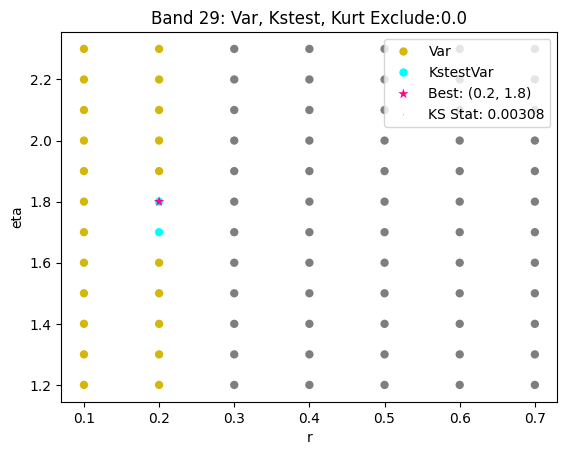

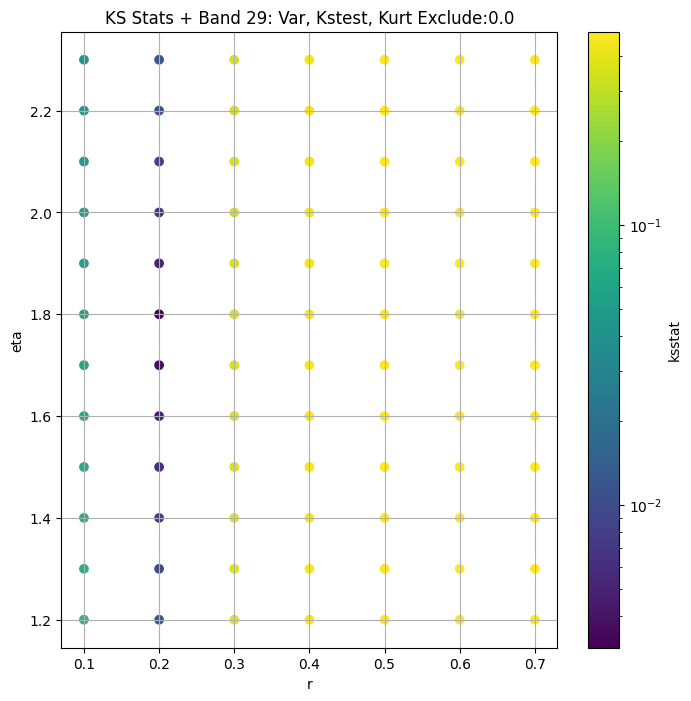

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,4.001831e+14,3.431550e+14,4.662308e+14,8.374412,4.737162,11.637278,2880.0,0.037611,0.1,9.6,9.501290e-07,0.0,4.001831e+14,0.025248
5,9.456641e+14,8.243140e+14,1.077068e+15,21.406433,18.218009,24.826738,8640.0,0.024745,0.1,5.1,1.250006e-04,100.0,3.760049e+14,0.014591
8,1.933607e+14,1.665212e+14,2.231191e+14,30.021908,21.785601,39.655766,24480.0,0.018369,0.1,8.0,8.324471e-07,250.0,7.884544e+13,0.008673
11,1.434549e+13,1.161038e+13,1.892118e+13,97.998144,13.797226,269.245611,67680.0,0.004281,0.2,8.1,3.130681e+04,150.0,9.763818e+12,0.005218
14,2.651968e+14,2.382959e+14,2.953186e+14,15.607562,10.288634,23.901440,100000.0,0.439677,0.1,0.4,5.104856e+00,100.0,2.430991e+14,0.004293
17,2.954061e+14,2.793516e+14,3.129828e+14,2.845135,1.622554,6.986594,100000.0,0.026861,0.2,14.0,8.424833e+04,350.0,2.673334e+14,0.004293
20,5.450353e+13,5.015239e+13,6.068562e+13,10.791890,3.758170,43.044204,100000.0,0.017362,0.1,14.0,4.651803e-09,150.0,4.949072e+13,0.004293
23,1.058599e+13,1.000795e+13,1.124110e+13,3.116213,1.811750,8.640072,100000.0,0.002004,0.1,13.0,1.901610e-09,0.0,1.058599e+13,0.004293
26,2.922161e+12,2.731516e+12,3.139131e+12,5.226006,3.111765,13.530244,100000.0,0.002315,0.1,7.1,7.969069e-08,0.0,2.922161e+12,0.004293


In [ ]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [ ]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/521 [00:00<?, ?it/s]

Finding Minimum after computing 521 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.06681304626194451, var: 181154706029957.88


  0%|          | 0/521 [00:00<?, ?it/s]

Finding Minimum after computing 521 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.05599492100390269, var: 200941658842706.25


  0%|          | 0/521 [00:00<?, ?it/s]

Finding Minimum after computing 521 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.047877894437744595, var: 227471227840961.38


  0%|          | 0/521 [00:00<?, ?it/s]

Finding Minimum after computing 521 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.04011702249497762, var: 267642421763642.72


  0%|          | 0/521 [00:00<?, ?it/s]

Finding Minimum after computing 521 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.037611271654568235, var: 400183110841747.1
Number of samples: 2880, Without approximation : 2880.0


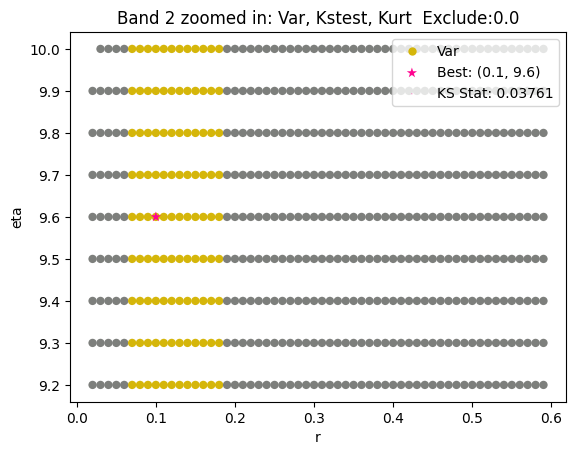

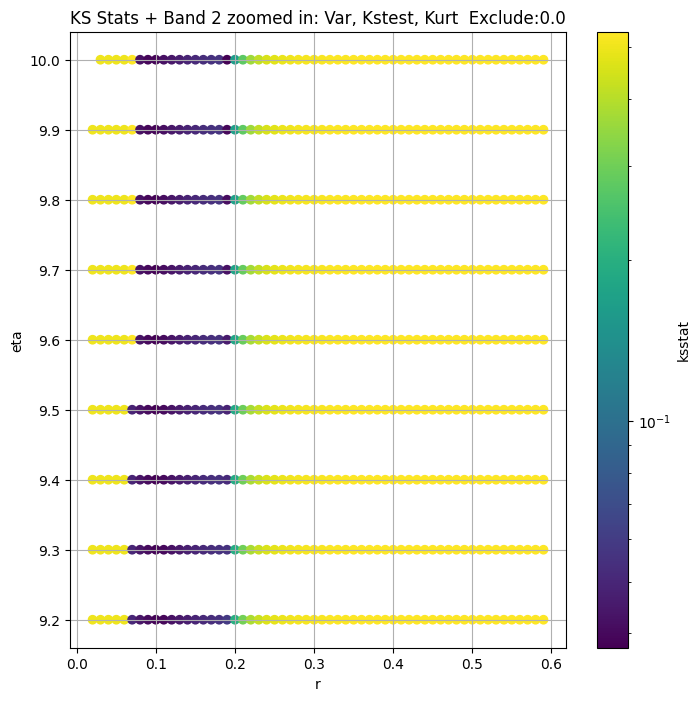

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.02946845968422296, var: 240179658850842.88


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.027520872757619608, var: 264328401801079.28


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.025532156927426053, var: 293794760894511.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.024316855581494795, var: 329505386284141.75


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.02474541685139975, var: 376004944022570.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.025746463059125535, var: 439430929320777.75


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.02781629170451827, var: 528201800465930.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.028335887655997927, var: 670336649641957.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.028335887655997927, var: 945664078461412.2
Number of samples: 8640, Without approximation : 8640.0


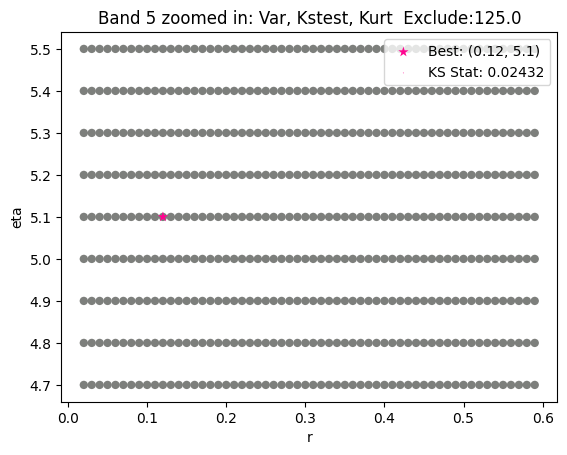

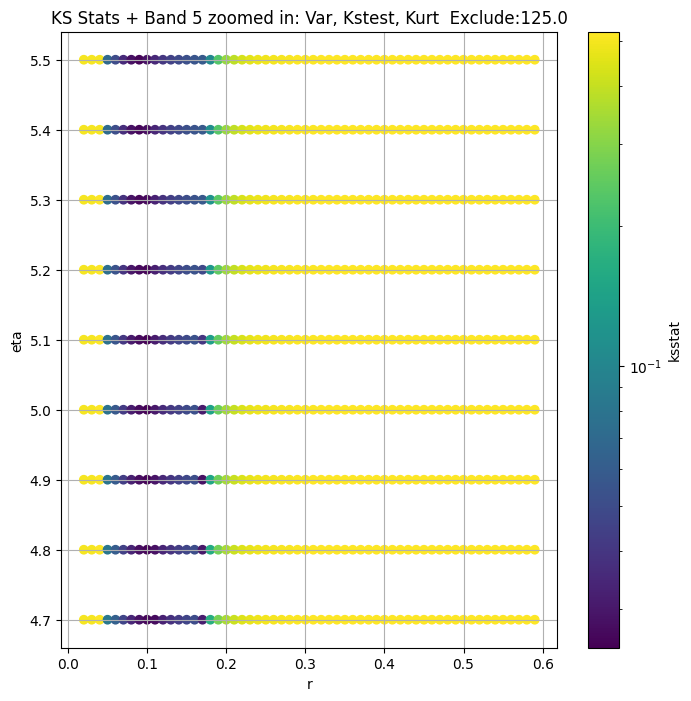

Band 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 250.0 + 100 = 350, ksstat: 0.019446248483168616, var: 66176058927539.695


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 250.0 + 75 = 325, ksstat: 0.01863760744008347, var: 68811582755078.35


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 250.0 + 50 = 300, ksstat: 0.018411941559376865, var: 71785001652756.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 250.0 + 25 = 275, ksstat: 0.018405943787634216, var: 75139165602126.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 250.0 + 0 = 250, ksstat: 0.018368674580637845, var: 78845444766077.86


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 250.0 + -25 = 225, ksstat: 0.018552924956333317, var: 83109087701953.78


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 250.0 + -50 = 200, ksstat: 0.0196797831550915, var: 87933453584094.4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 250.0 + -75 = 175, ksstat: 0.020291297168511135, var: 93335330312645.27


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 250.0 + -100 = 150, ksstat: 0.021300859543567974, var: 99580913820581.55
Number of samples: 24480, Without approximation : 24480.0


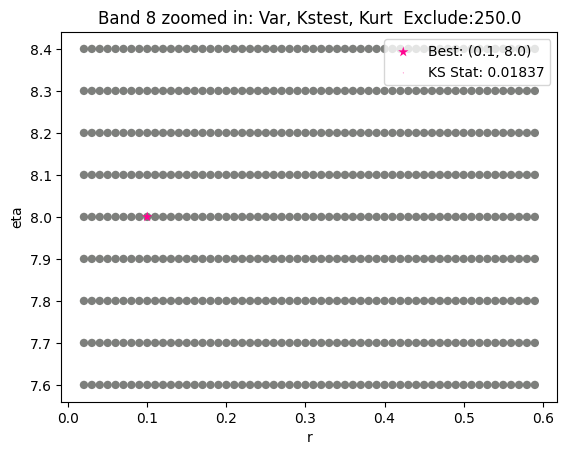

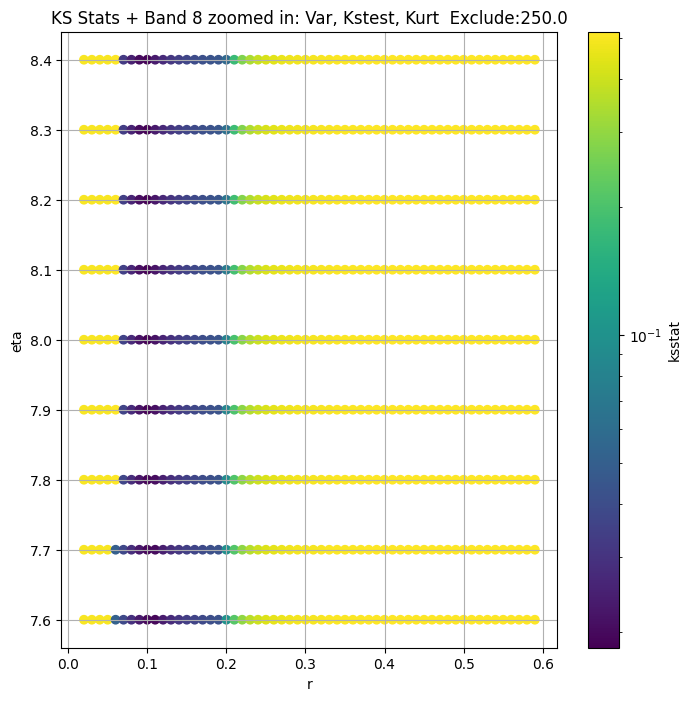

Band 11


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 100 = 250, ksstat: 0.00784936257917812, var: 9170001571118.111


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 75 = 225, ksstat: 0.006360200784751746, var: 9301351883839.652


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 50 = 200, ksstat: 0.0047821009838188155, var: 9442922209778.535


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 25 = 175, ksstat: 0.004244287739660235, var: 9596672324696.953


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 0 = 150, ksstat: 0.00428090663502409, var: 9763818291062.88


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -25 = 125, ksstat: 0.004344266678923528, var: 9954779927709.73


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -50 = 100, ksstat: 0.004344266678923528, var: 10175480479255.727


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -75 = 75, ksstat: 0.004344266678923528, var: 10452796582917.295


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -100 = 50, ksstat: 0.004344266678923528, var: 10813017278543.252
Number of samples: 67680, Without approximation : 67680.0


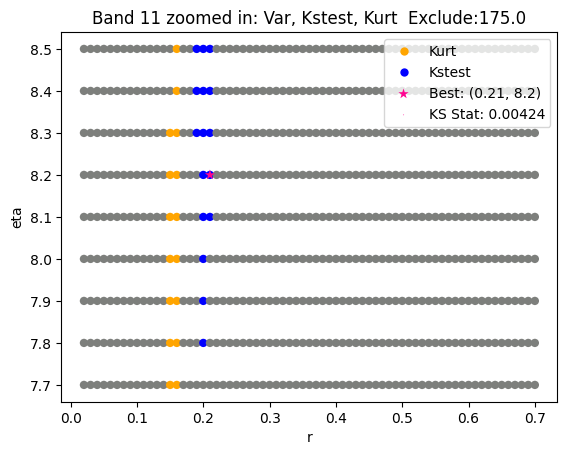

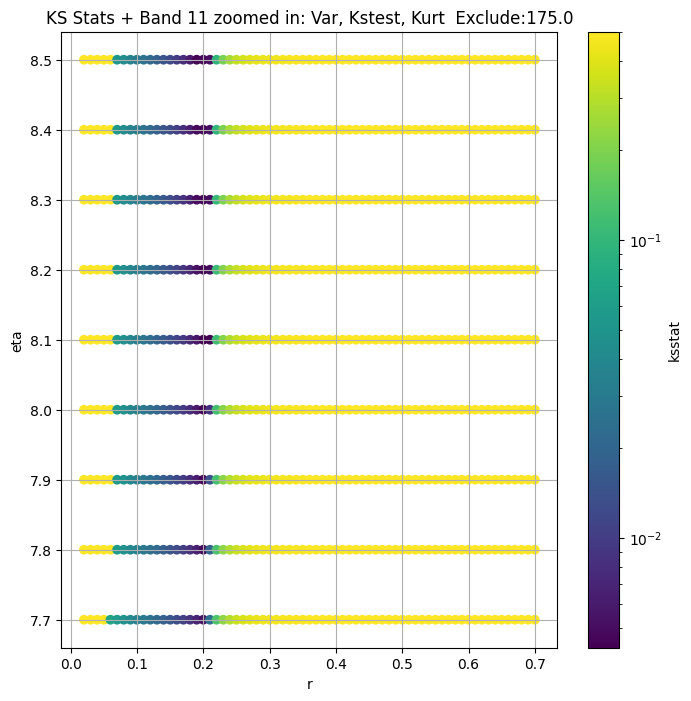

Band 14


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 14, 100.0 + 100 = 200, ksstat: 0.43976618252232474, var: 231488544247345.22


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 14, 100.0 + 75 = 175, ksstat: 0.44000395034032885, var: 234038398896208.9


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 14, 100.0 + 50 = 150, ksstat: 0.43989421094127434, var: 236800625306505.6


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 14, 100.0 + 25 = 125, ksstat: 0.43977723992000606, var: 239797398870271.1


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 14, 100.0 + 0 = 100, ksstat: 0.43967698606895833, var: 243099076326729.5


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 14, 100.0 + -25 = 75, ksstat: 0.4397187210311686, var: 246824736596911.94


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 14, 100.0 + -50 = 50, ksstat: 0.43977481658598727, var: 251311020749658.3


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 14, 100.0 + -75 = 25, ksstat: 0.4400426086256035, var: 256558423077402.66


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 14, 100.0 + -100 = 0, ksstat: 0.44001251553861154, var: 265196808520432.28
Number of samples: 100000, Without approximation : 100000.0


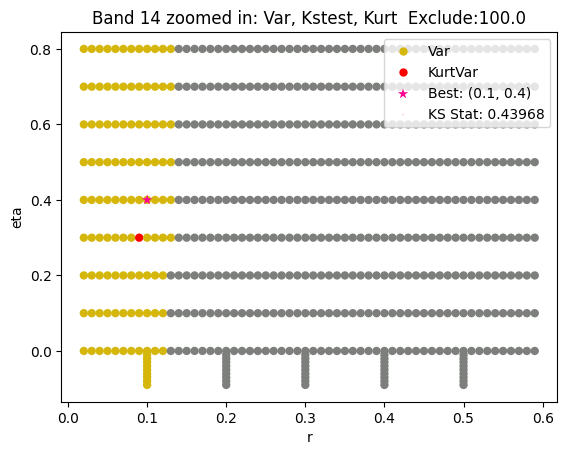

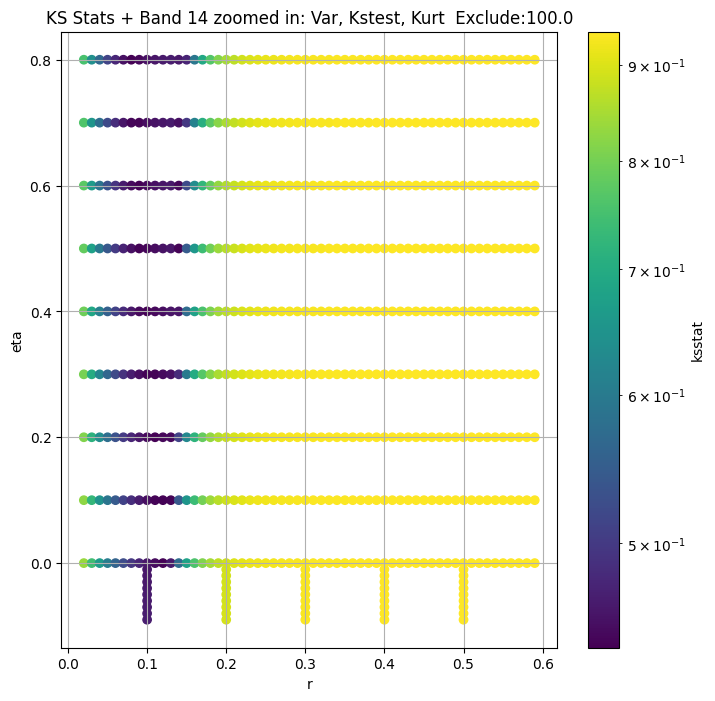

Band 17


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 17, 350.0 + 100 = 450, ksstat: 0.027849039119540744, var: 262231560451831.97


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 17, 350.0 + 75 = 425, ksstat: 0.02740481092999636, var: 263462845023354.44


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 17, 350.0 + 50 = 400, ksstat: 0.026951657678833674, var: 264722161043183.16


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 17, 350.0 + 25 = 375, ksstat: 0.02652954478570313, var: 266010853494261.5


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 17, 350.0 + 0 = 350, ksstat: 0.026440588199553722, var: 267333430424080.66


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 17, 350.0 + -25 = 325, ksstat: 0.02640770058815589, var: 268691751665566.94


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 17, 350.0 + -50 = 300, ksstat: 0.025940717982685754, var: 270086415607397.66


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 17, 350.0 + -75 = 275, ksstat: 0.025968948601673467, var: 271529551624006.4


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 17, 350.0 + -100 = 250, ksstat: 0.025641524399416138, var: 273028763914249.56
Number of samples: 100000, Without approximation : 100000.0


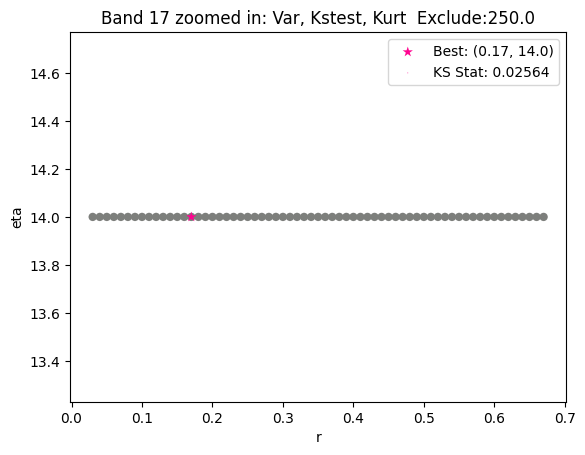

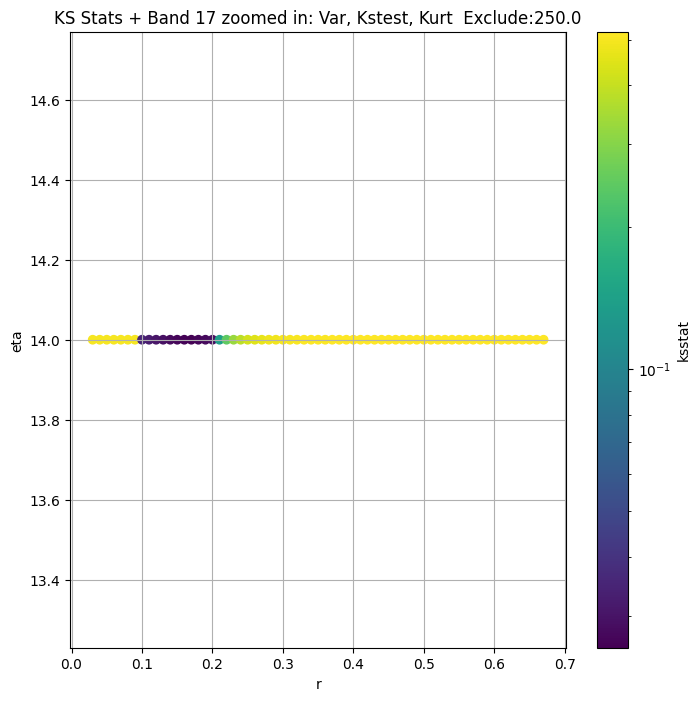

Band 20


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 150.0 + 100 = 250, ksstat: 0.018099038272039347, var: 47827910850071.16


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 150.0 + 75 = 225, ksstat: 0.017914406605062716, var: 48208046154781.17


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 150.0 + 50 = 200, ksstat: 0.017731697775853303, var: 48607970663260.64


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 150.0 + 25 = 175, ksstat: 0.017081886968705495, var: 49033806182139.65


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 150.0 + 0 = 150, ksstat: 0.017361528877421373, var: 49490719631125.586


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 150.0 + -25 = 125, ksstat: 0.01779110852947663, var: 49984298066467.54


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 150.0 + -50 = 100, ksstat: 0.018884755584504975, var: 50523090795227.92


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 150.0 + -75 = 75, ksstat: 0.020095588767234385, var: 51126765643474.84


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 20, 150.0 + -100 = 50, ksstat: 0.021486964743853587, var: 51830286263171.99
Number of samples: 100000, Without approximation : 100000.0


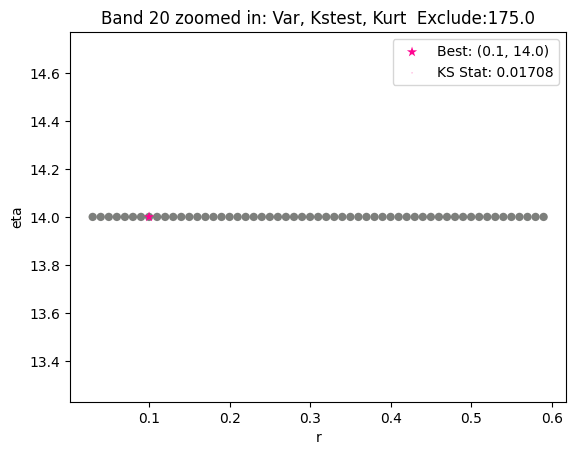

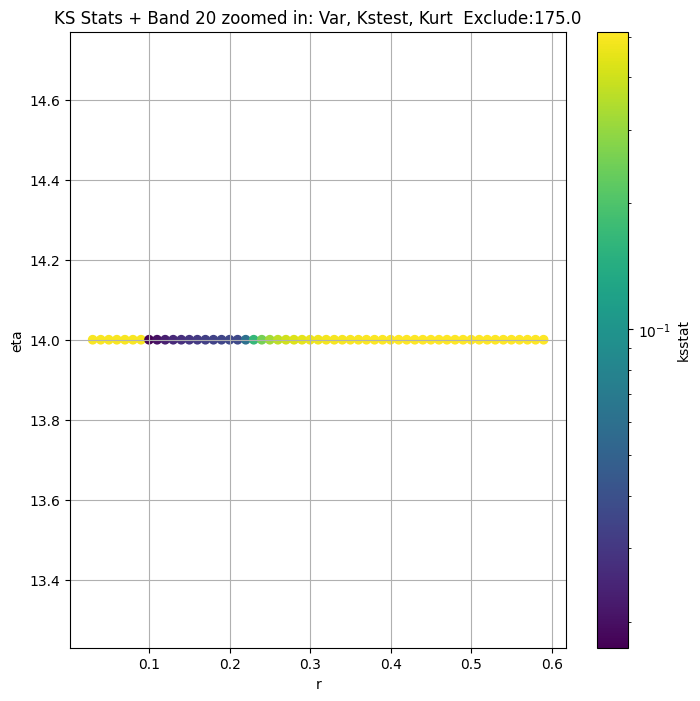

Band 23


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 0.0 + 100 = 100, ksstat: 0.0037574615467184866, var: 10073323772116.146


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 0.0 + 75 = 75, ksstat: 0.0032816435015228795, var: 10169003506220.877


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 0.0 + 50 = 50, ksstat: 0.002769485428965164, var: 10274632951872.697


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 0.0 + 25 = 25, ksstat: 0.002221891257128898, var: 10396960793912.223


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 0.0 + 0 = 0, ksstat: 0.0020037618301408378, var: 10585992784056.541
Number of samples: 100000, Without approximation : 100000.0


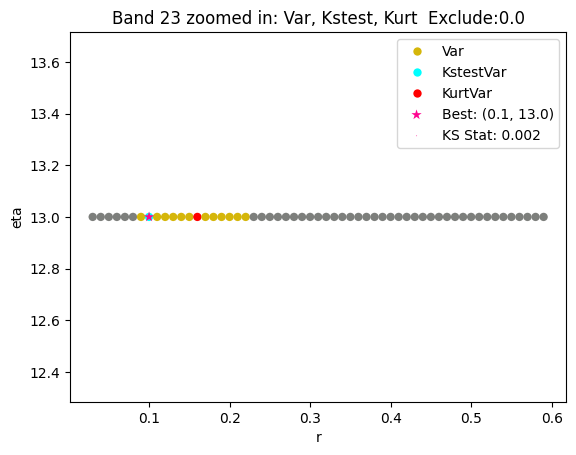

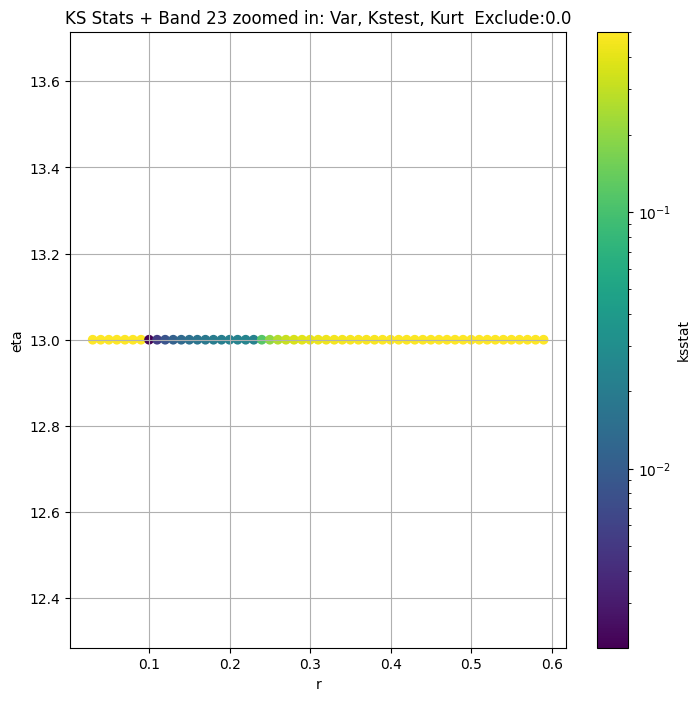

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 100 = 100, ksstat: 0.004746553617765083, var: 2739380278125.882


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 75 = 75, ksstat: 0.004309289326272392, var: 2772682628576.879


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 50 = 50, ksstat: 0.0037250448834271963, var: 2809943426935.955


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 25 = 25, ksstat: 0.0031275732077024887, var: 2853720783639.27


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 0 = 0, ksstat: 0.002315202716388118, var: 2922160721669.784
Number of samples: 100000, Without approximation : 100000.0


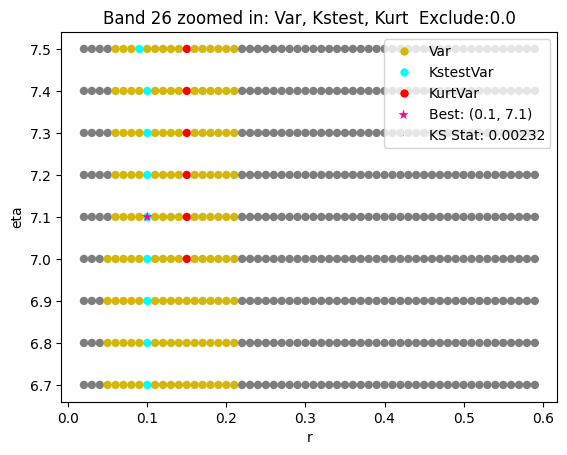

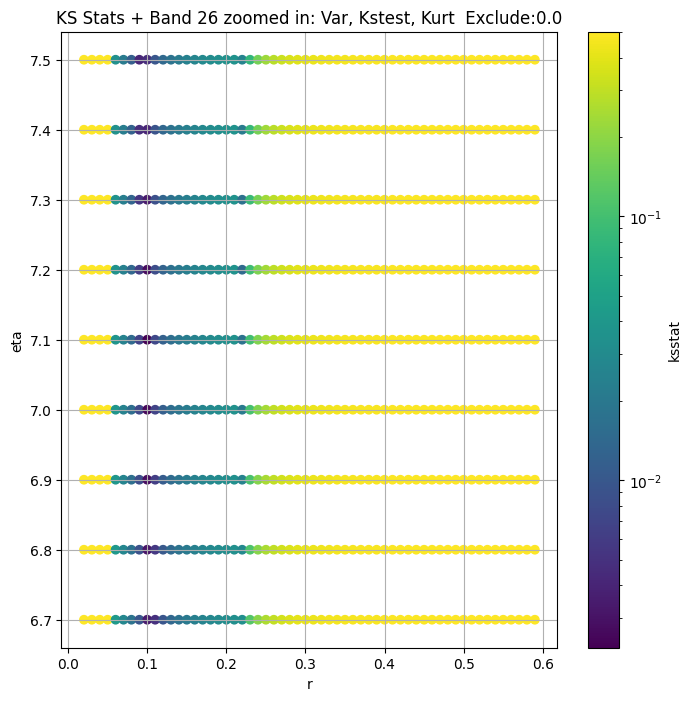

Band 29


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 29, 0.0 + 100 = 100, ksstat: 0.005500867316553346, var: 59699636524.74617


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 29, 0.0 + 75 = 75, ksstat: 0.005084546398039458, var: 60457763301.36296


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 29, 0.0 + 50 = 50, ksstat: 0.004622946242499884, var: 61299594294.33173


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 29, 0.0 + 25 = 25, ksstat: 0.0040694214437148185, var: 62271402993.634285


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
band 29, 0.0 + 0 = 0, ksstat: 0.0030849426229090093, var: 63717506363.97226
Number of samples: 100000, Without approximation : 100000.0


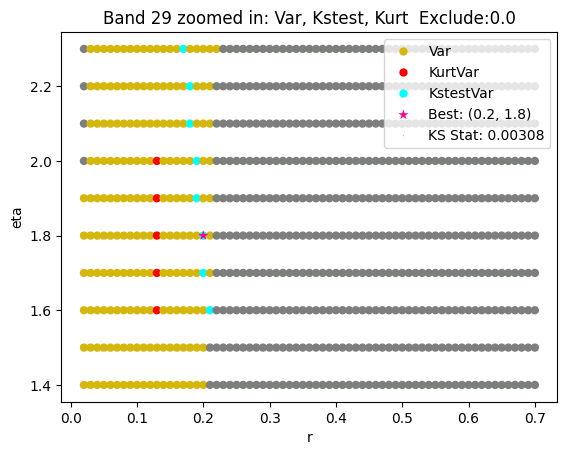

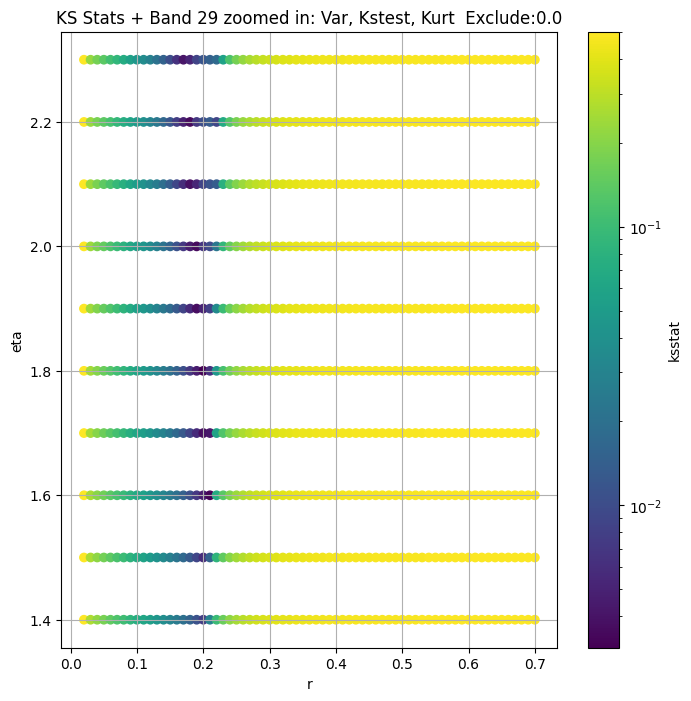

Not a fit


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,4.001831e+14,3.431550e+14,4.662308e+14,8.374412,4.737162,11.637278,2880.0,0.037611,0.1,9.6,9.501290e-07,0.0,4.001831e+14,0.025248,0.037611,0.10,9.6,9.501290e-07,0.0,1366
5,9.456641e+14,8.243140e+14,1.077068e+15,21.406433,18.218009,24.826738,8640.0,0.024745,0.1,5.1,1.250006e-04,100.0,3.295054e+14,0.014591,0.024317,0.12,5.1,6.085140e-01,125.0,3240
8,1.933607e+14,1.665212e+14,2.231191e+14,30.021908,21.785601,39.655766,24480.0,0.018369,0.1,8.0,8.324471e-07,250.0,7.884544e+13,0.008673,0.018369,0.10,8.0,8.324471e-07,250.0,5512
11,1.434549e+13,1.161038e+13,1.892118e+13,97.998144,13.797226,269.245611,67680.0,0.004281,0.2,8.1,3.130681e+04,150.0,9.596672e+12,0.005218,0.004244,0.21,8.2,9.417673e+04,175.0,101520
14,2.651968e+14,2.382959e+14,2.953186e+14,15.607562,10.288634,23.901440,100000.0,0.439677,0.1,0.4,5.104856e+00,100.0,2.430991e+14,0.004293,0.439677,0.10,0.4,5.104856e+00,100.0,-1
17,2.954061e+14,2.793516e+14,3.129828e+14,2.845135,1.622554,6.986594,100000.0,0.026861,0.2,14.0,8.424833e+04,350.0,2.730288e+14,0.004293,0.025642,0.17,14.0,6.924601e+02,250.0,2812
20,5.450353e+13,5.015239e+13,6.068562e+13,10.791890,3.758170,43.044204,100000.0,0.017362,0.1,14.0,4.651803e-09,150.0,4.903381e+13,0.004293,0.017082,0.10,14.0,4.608856e-09,175.0,6250
23,1.058599e+13,1.000795e+13,1.124110e+13,3.116213,1.811750,8.640072,100000.0,0.002004,0.1,13.0,1.901610e-09,0.0,1.058599e+13,0.004293,0.002004,0.10,13.0,1.901610e-09,0.0,480540
26,2.922161e+12,2.731516e+12,3.139131e+12,5.226006,3.111765,13.530244,100000.0,0.002315,0.1,7.1,7.969069e-08,0.0,2.922161e+12,0.004293,0.002315,0.10,7.1,7.969069e-08,0.0,337500


In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

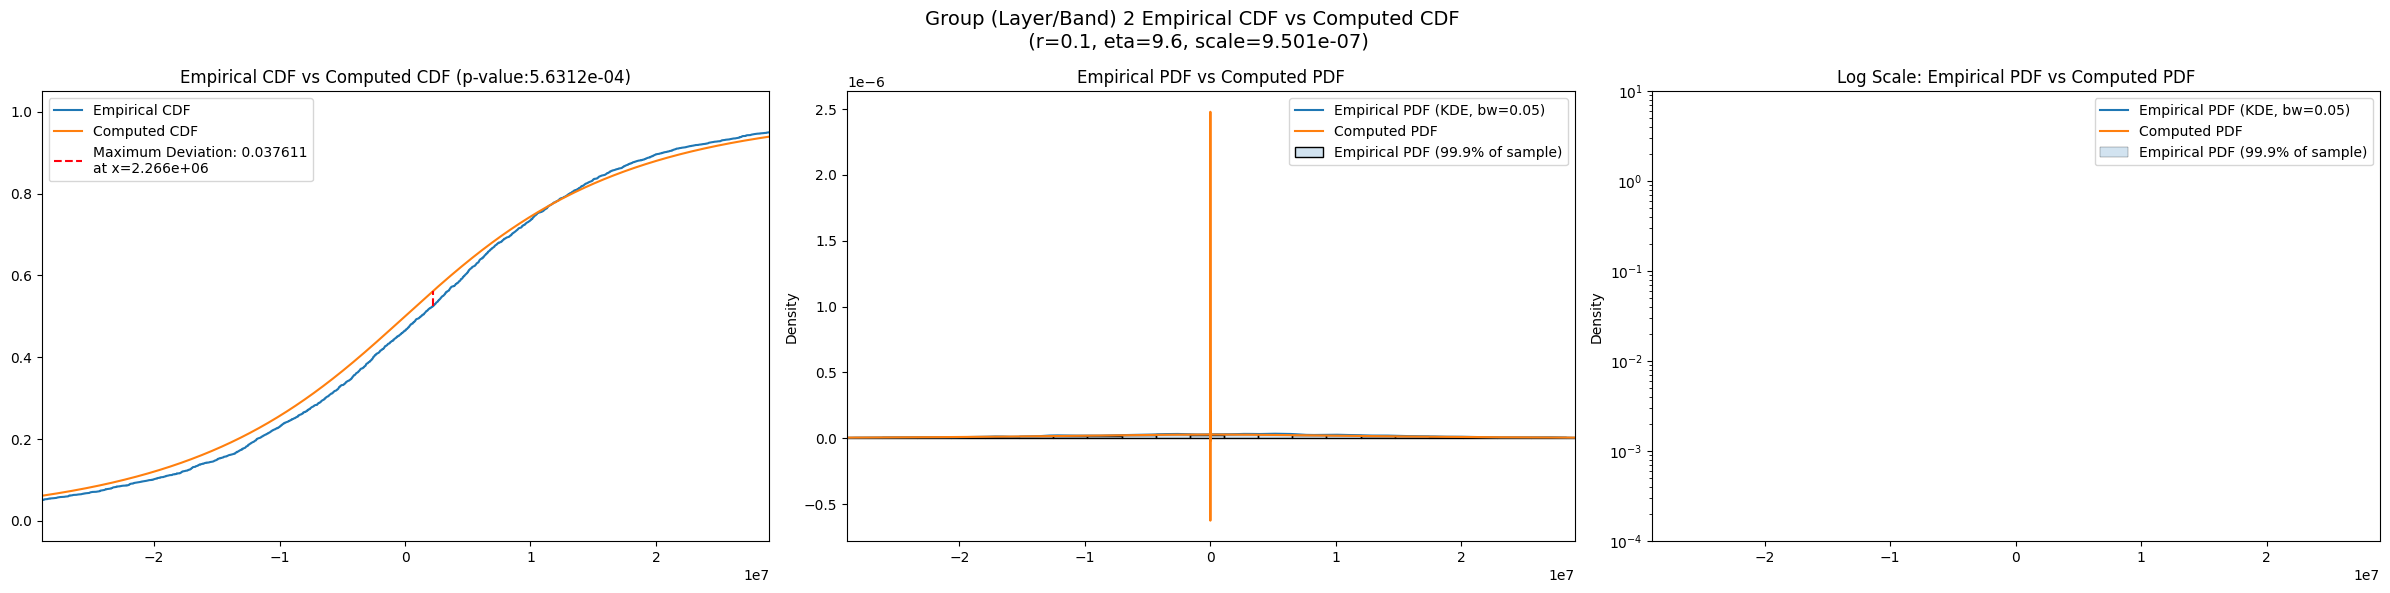

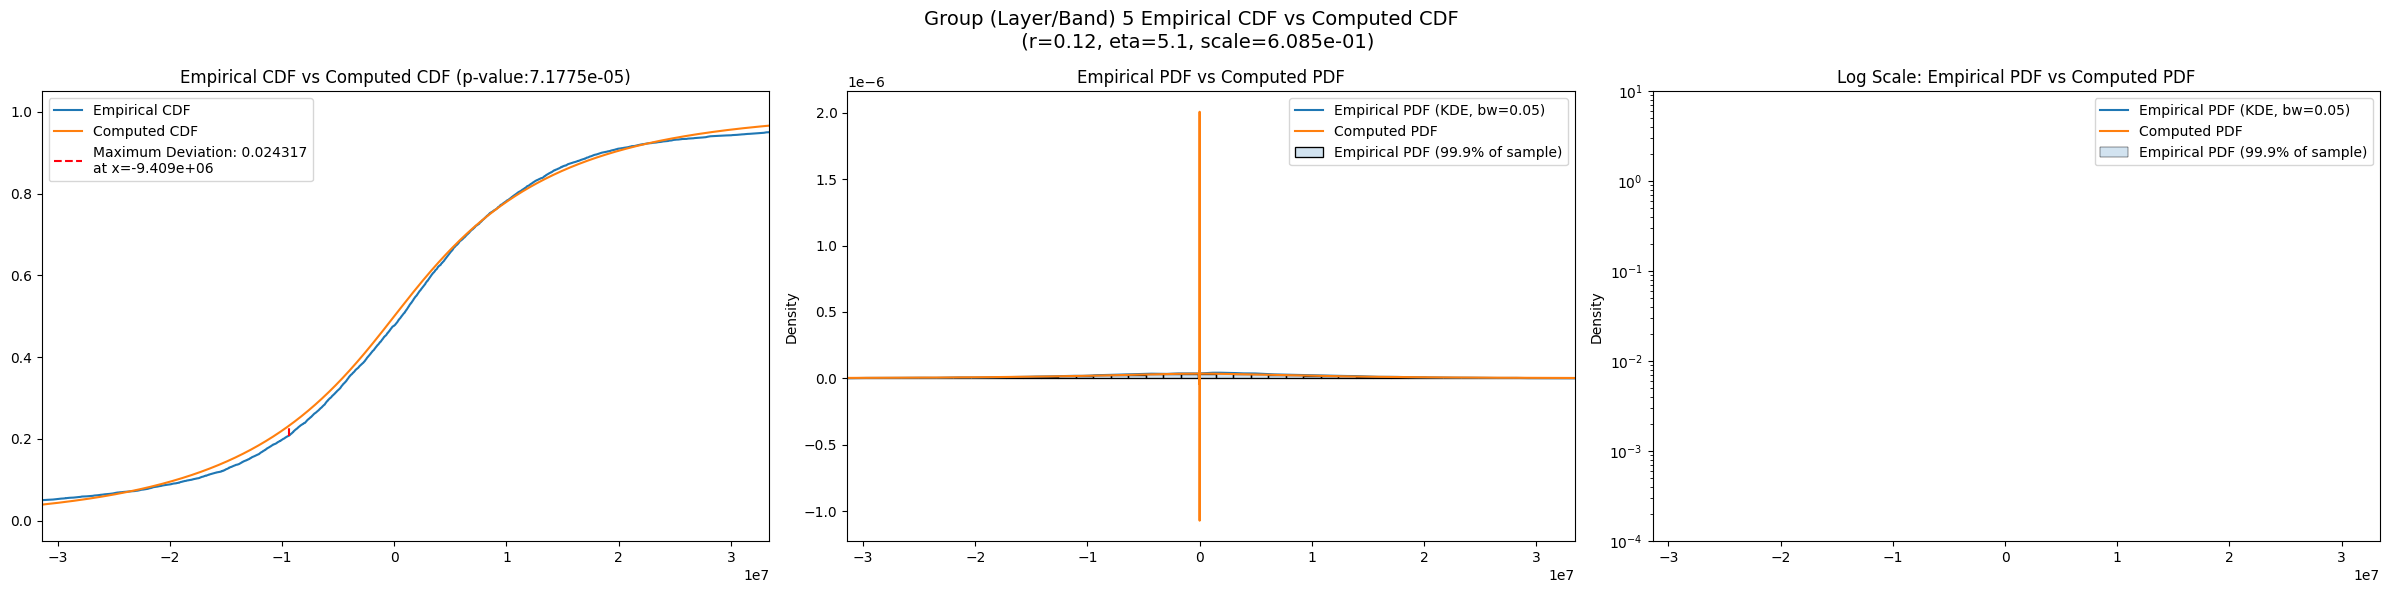

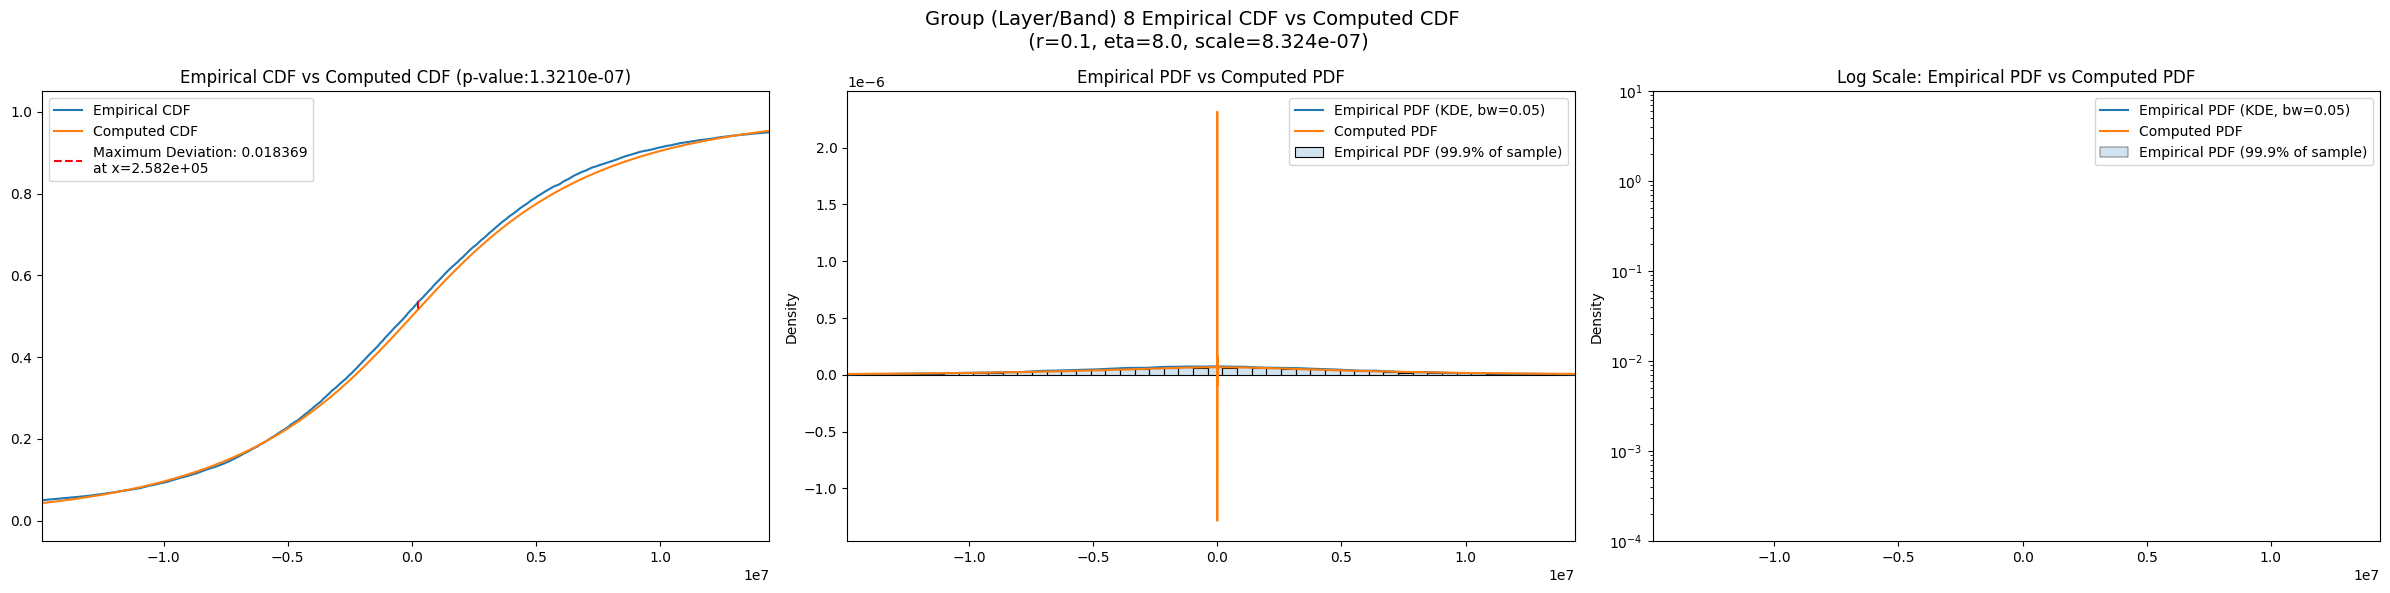

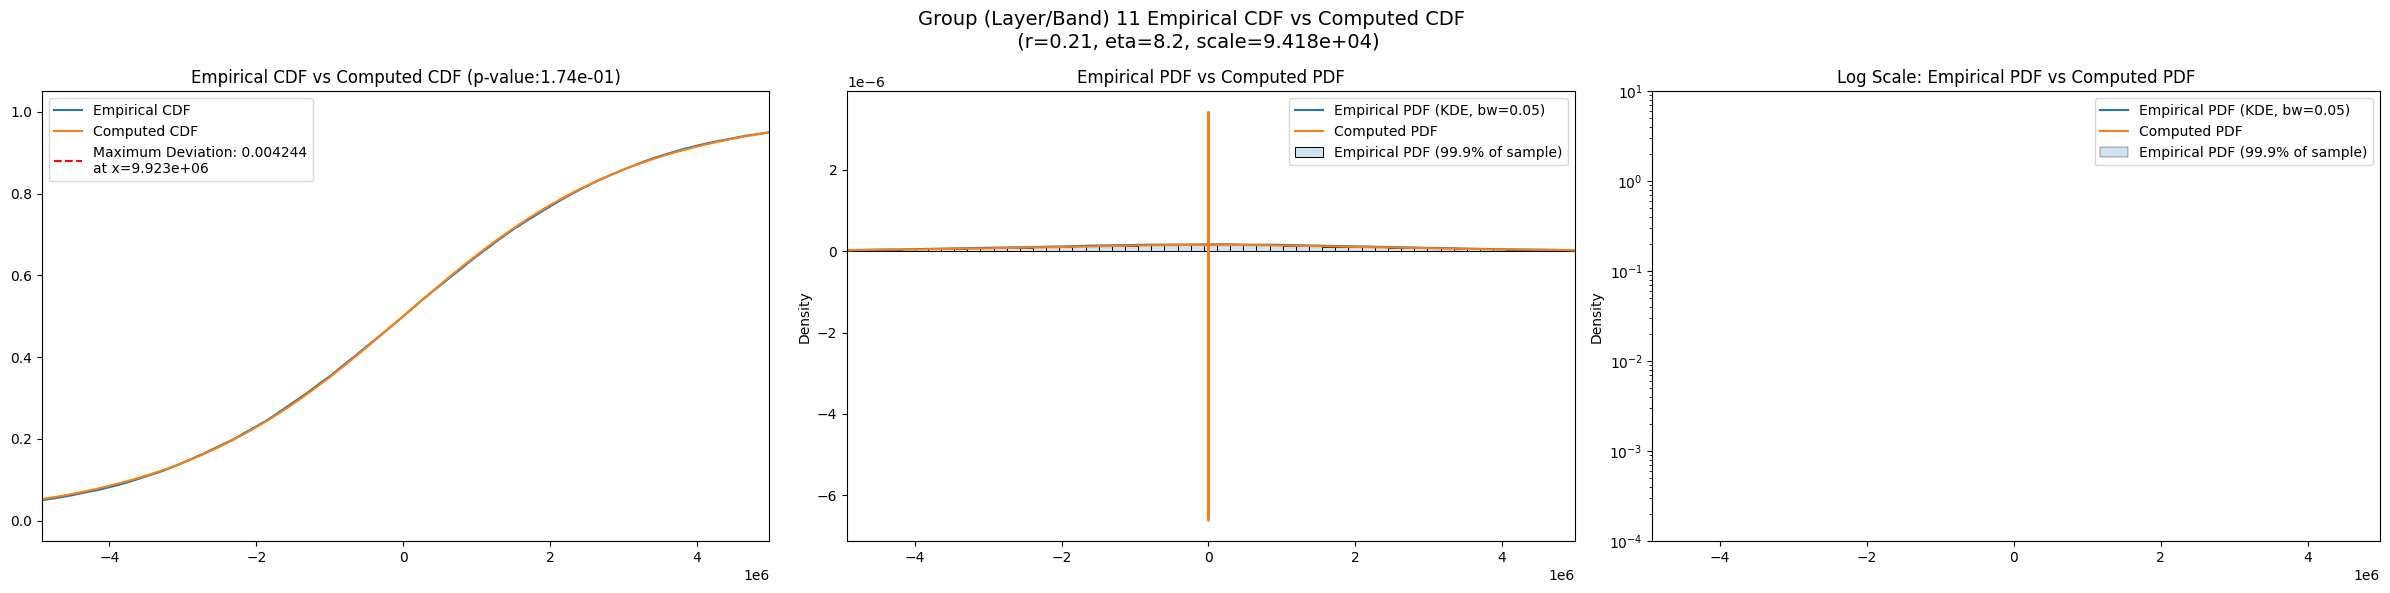

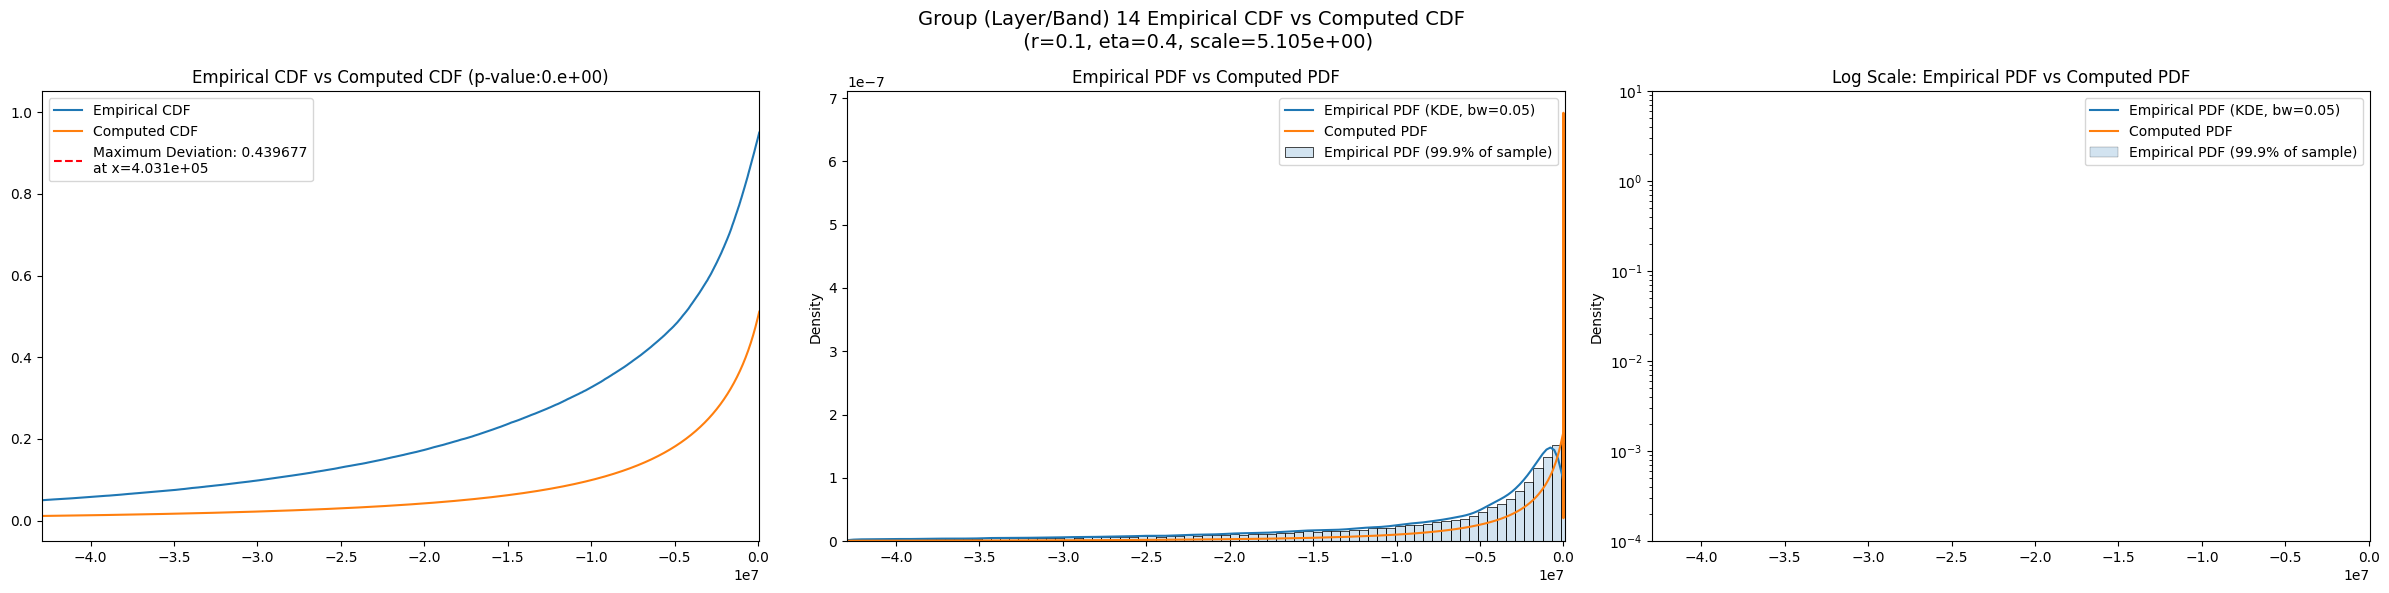

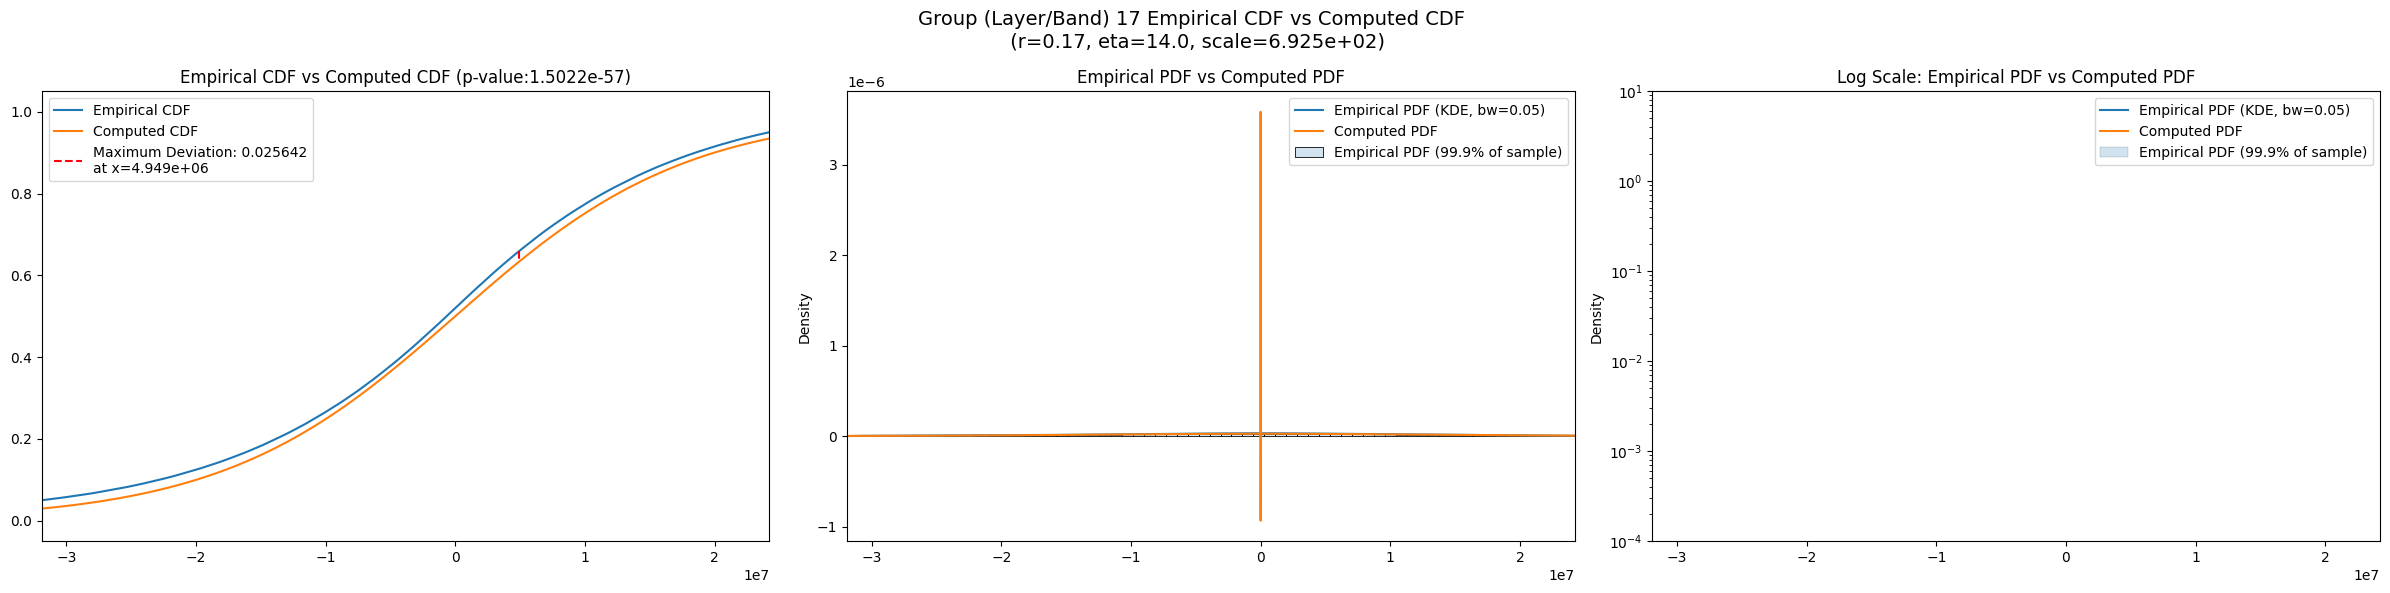

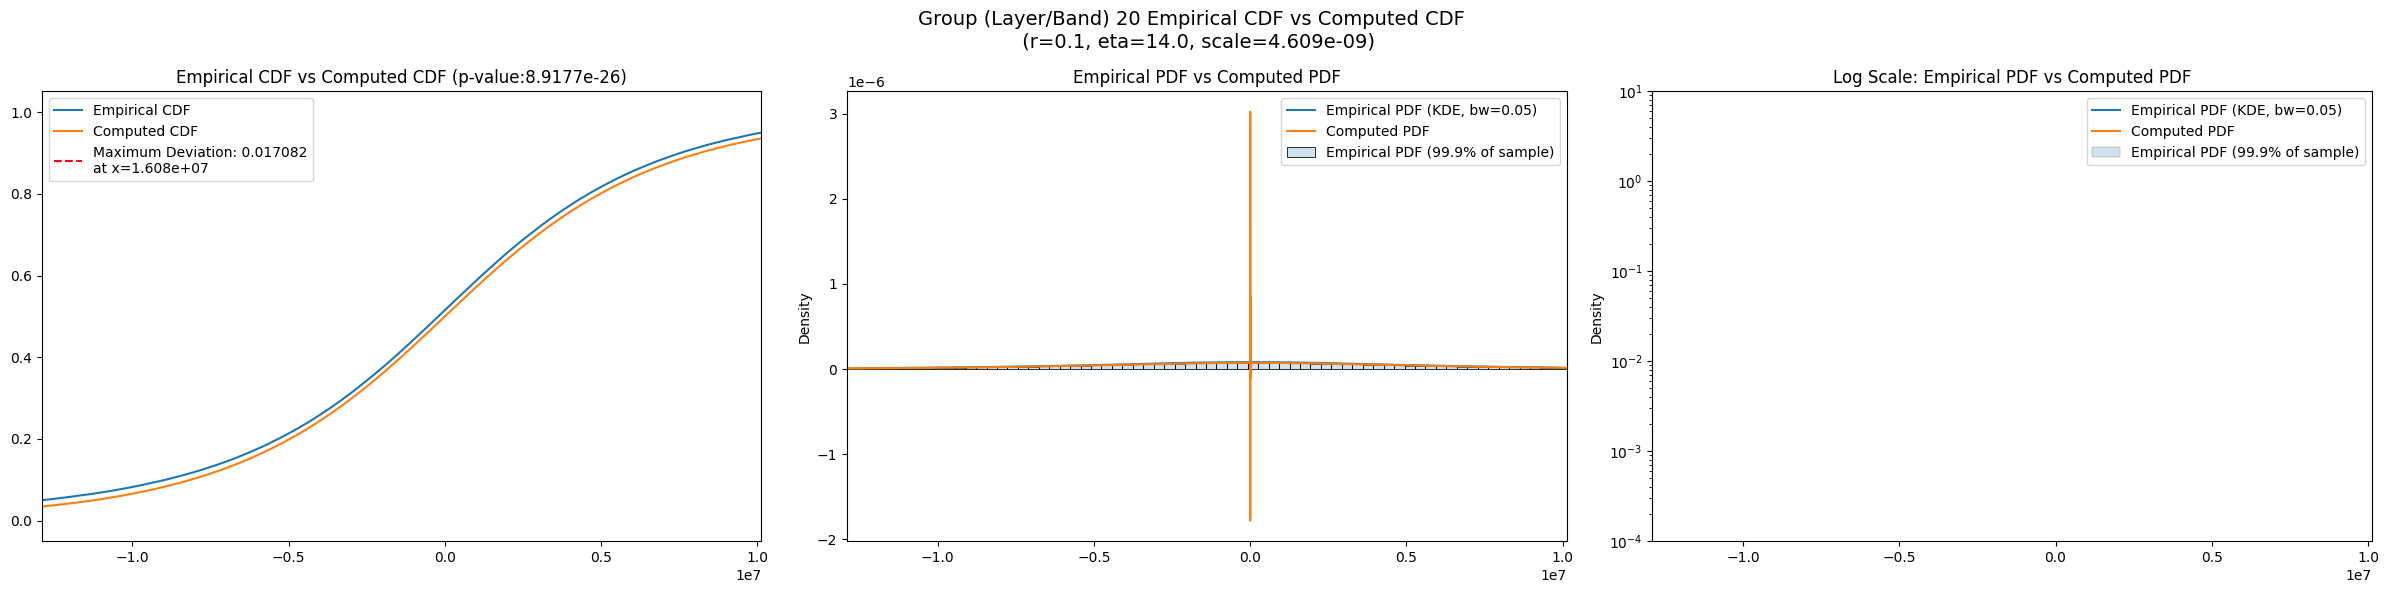

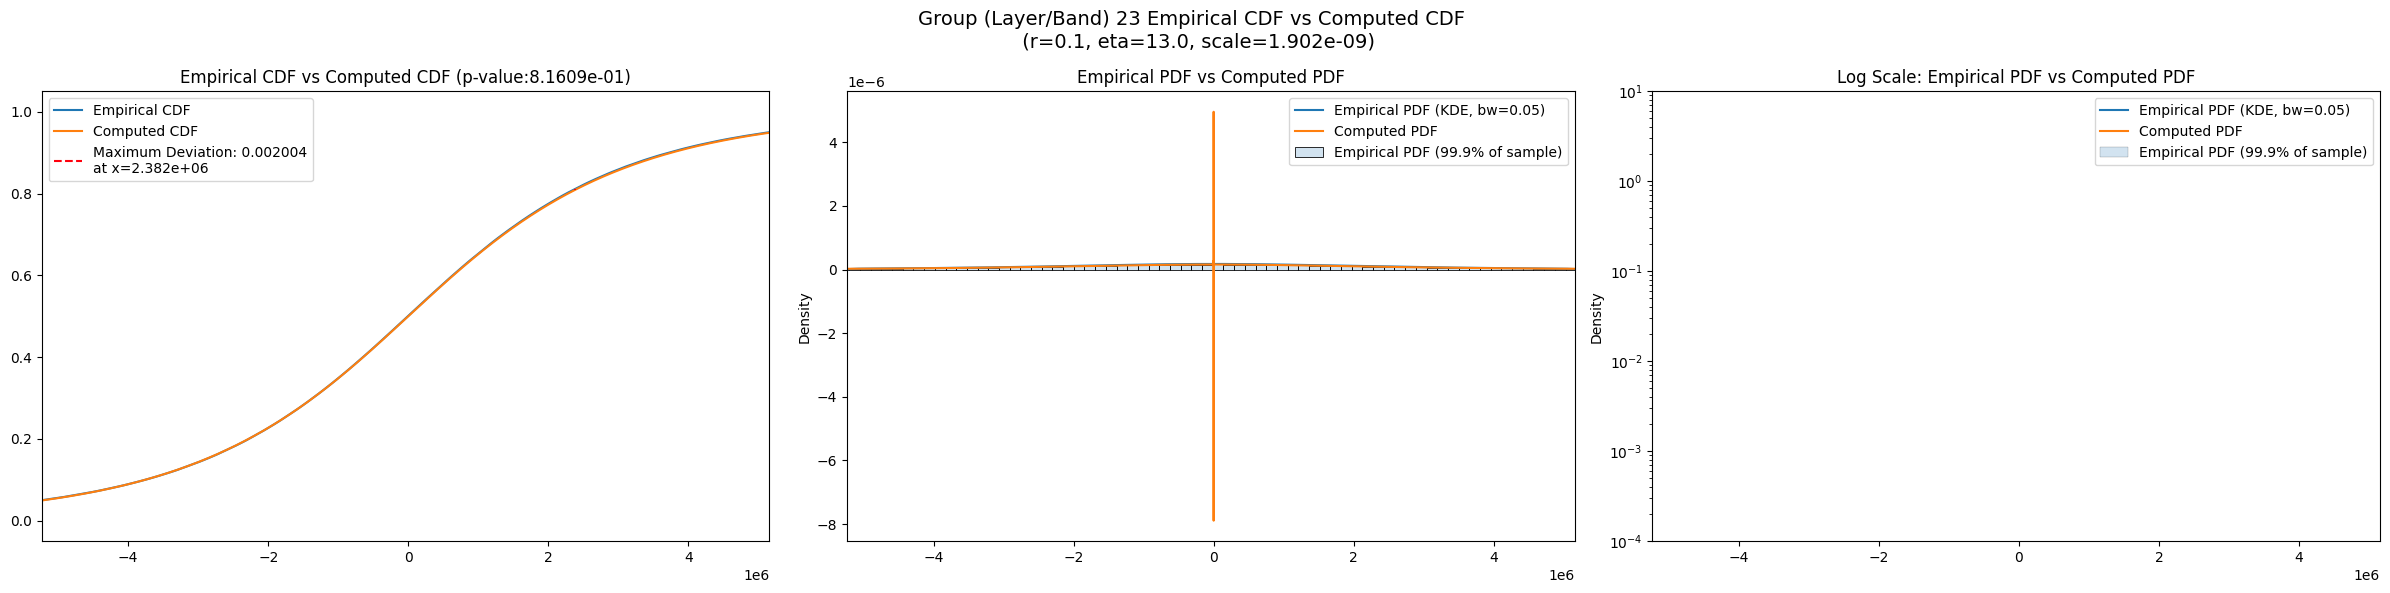

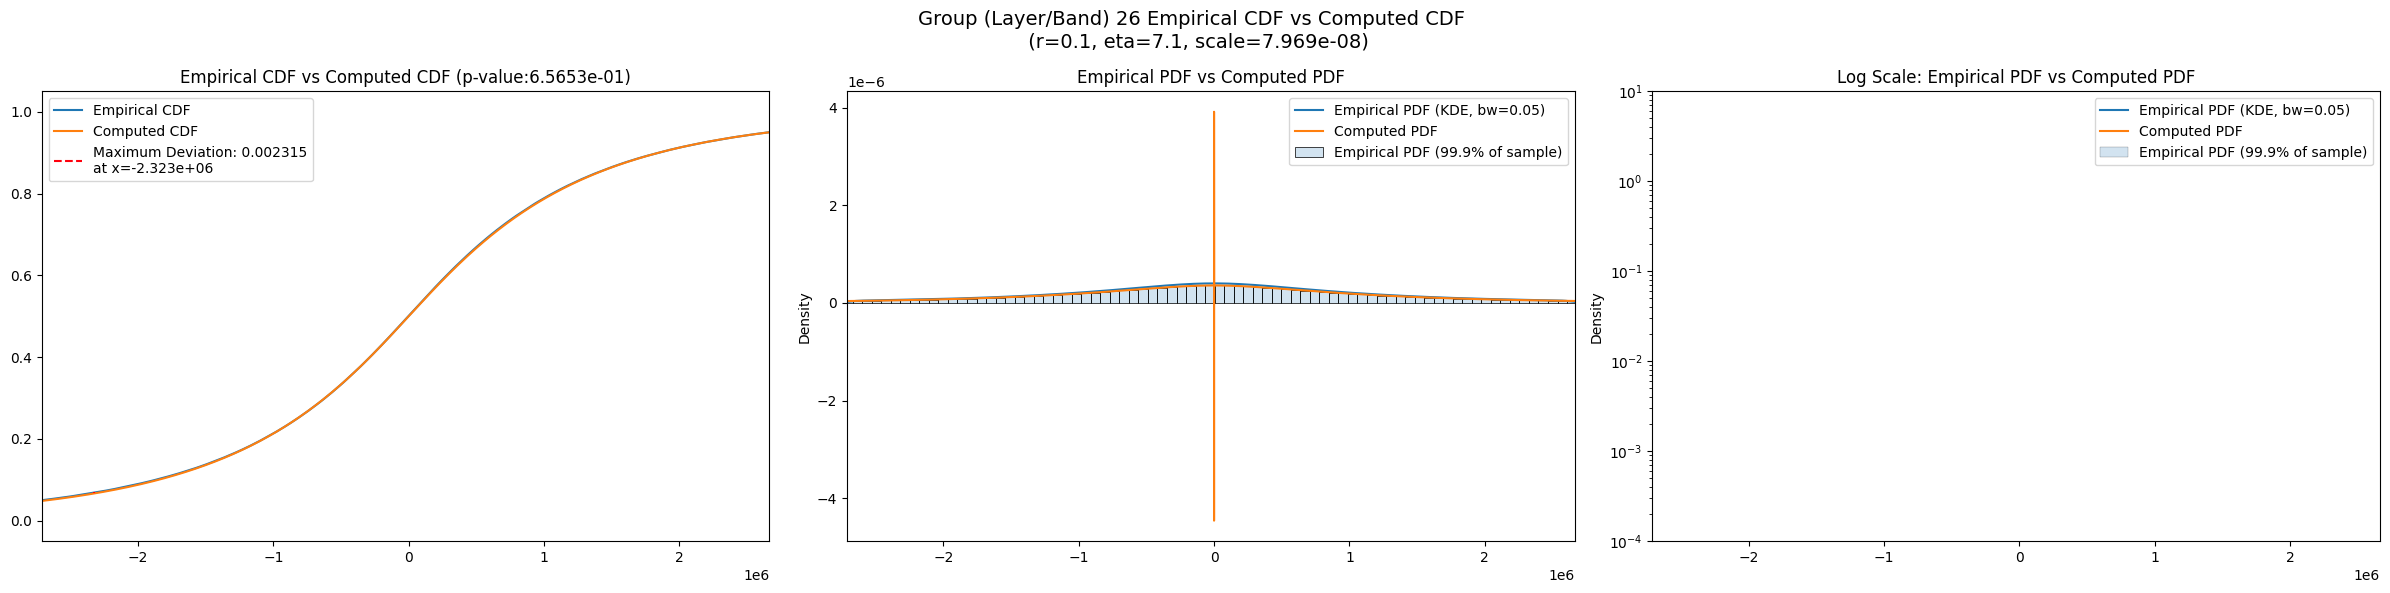

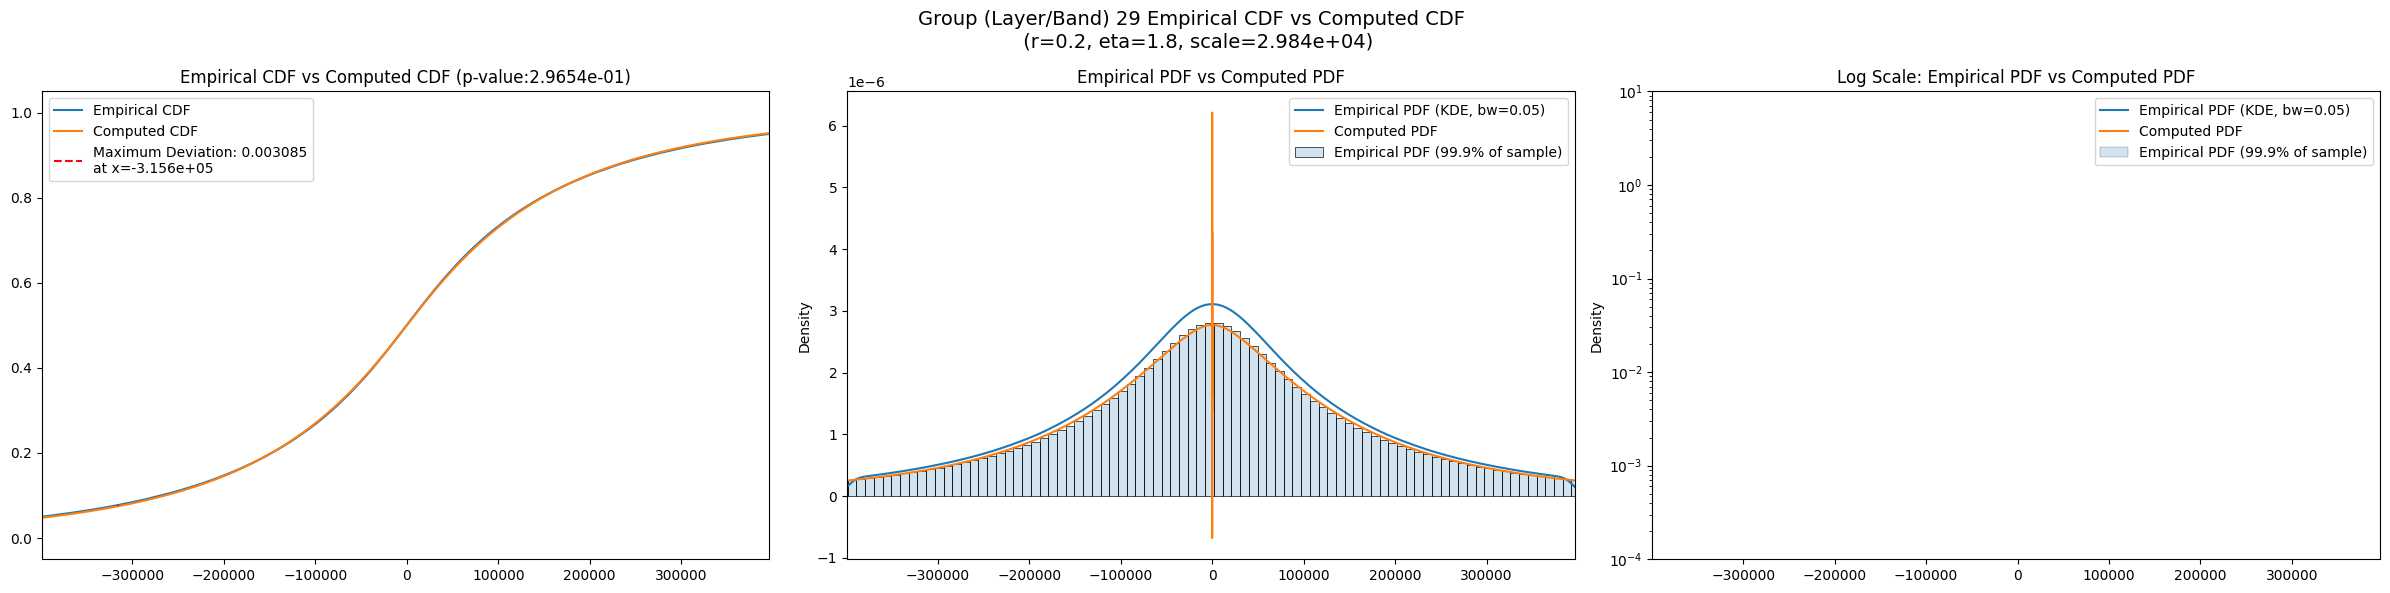

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,4.001831e+14,3.431550e+14,4.662308e+14,8.374412,4.737162,11.637278,2880.0,0.037611,0.1,9.6,...,1000000.0,0.463271,0.000000e+00,1000000.0,0.427800,0.000000e+00,1000000.0,0.404357,0.000000e+00,5.631232e-04
5,9.456641e+14,8.243140e+14,1.077068e+15,21.406433,18.218009,24.826738,8640.0,0.024745,0.1,5.1,...,1000000.0,0.427773,0.000000e+00,1000000.0,0.390553,0.000000e+00,1000000.0,0.367104,0.000000e+00,7.177498e-05
8,1.933607e+14,1.665212e+14,2.231191e+14,30.021908,21.785601,39.655766,24480.0,0.018369,0.1,8.0,...,1000000.0,0.365776,0.000000e+00,1000000.0,0.320709,0.000000e+00,1000000.0,0.296621,0.000000e+00,1.321016e-07
11,1.434549e+13,1.161038e+13,1.892118e+13,97.998144,13.797226,269.245611,67680.0,0.004281,0.2,8.1,...,1000000.0,0.222367,0.000000e+00,1000000.0,0.178273,0.000000e+00,1000000.0,0.153217,0.000000e+00,1.739972e-01
14,2.651968e+14,2.382959e+14,2.953186e+14,15.607562,10.288634,23.901440,100000.0,0.439677,0.1,0.4,...,1000000.0,0.661500,0.000000e+00,1000000.0,0.616361,0.000000e+00,1000000.0,0.591579,0.000000e+00,0.000000e+00
17,2.954061e+14,2.793516e+14,3.129828e+14,2.845135,1.622554,6.986594,100000.0,0.026861,0.2,14.0,...,1000000.0,0.441776,0.000000e+00,1000000.0,0.407657,0.000000e+00,1000000.0,0.384663,0.000000e+00,1.502180e-57
20,5.450353e+13,5.015239e+13,6.068562e+13,10.791890,3.758170,43.044204,100000.0,0.017362,0.1,14.0,...,1000000.0,0.352567,0.000000e+00,1000000.0,0.307068,0.000000e+00,1000000.0,0.282999,0.000000e+00,8.909723e-26
23,1.058599e+13,1.000795e+13,1.124110e+13,3.116213,1.811750,8.640072,100000.0,0.002004,0.1,13.0,...,1000000.0,0.216509,0.000000e+00,1000000.0,0.172218,0.000000e+00,1000000.0,0.147241,0.000000e+00,8.160720e-01
26,2.922161e+12,2.731516e+12,3.139131e+12,5.226006,3.111765,13.530244,100000.0,0.002315,0.1,7.1,...,1000000.0,0.071405,0.000000e+00,1000000.0,0.030763,1.185670e-82,962538.0,0.009665,1.527430e-08,6.564042e-01


## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.037611,0.025248,0.037611,0.463271,0.427800,0.404357
5,0.024745,0.014591,0.024317,0.427773,0.390553,0.367104
8,0.018369,0.008673,0.018369,0.365776,0.320709,0.296621
11,0.004281,0.005218,0.004244,0.222367,0.178273,0.153217
14,0.439677,0.004293,0.439677,0.661500,0.616361,0.591579
17,0.026861,0.004293,0.025642,0.441776,0.407657,0.384663
20,0.017362,0.004293,0.017082,0.352567,0.307068,0.282999
23,0.002004,0.004293,0.002004,0.216509,0.172218,0.147241
26,0.002315,0.004293,0.002315,0.071405,0.030763,0.009665


In [ ]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,4.001831e+14,0.037611,0.10,9.6,9.501290e-07,0.0
5,3.295054e+14,0.024317,0.12,5.1,6.085140e-01,125.0
8,7.884544e+13,0.018369,0.10,8.0,8.324471e-07,250.0
11,9.596672e+12,0.004244,0.21,8.2,9.417673e+04,175.0
14,2.430991e+14,0.439677,0.10,0.4,5.104856e+00,100.0
17,2.730288e+14,0.025642,0.17,14.0,6.924601e+02,250.0
20,4.903381e+13,0.017082,0.10,14.0,4.608856e-09,175.0
23,1.058599e+13,0.002004,0.10,13.0,1.901610e-09,0.0
26,2.922161e+12,0.002315,0.10,7.1,7.969069e-08,0.0
